# Preprocesamiento de los datos

In [ ]:
import pandas as pd
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del directorio donde están los archivos TXT
directory = '/content/drive/My Drive/E-c_AIT-EN/'

# Lista de nombres de archivos (actualizada con los 3 archivos de la tarea E-c)
file_names = [
    '2018-E-c-En-train.txt',
    '2018-E-c-En-test-gold.txt',
    '2018-E-c-En-dev.txt'
]

# Lista de emociones permitidas
allowed_emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'no emotion']

# Función para reestructurar los datos
def restructure_data(df):
    # Obtener las columnas de emociones (a partir de la segunda columna)
    emotion_columns = df.columns[2:].tolist()

    # Crear una lista para almacenar las nuevas filas
    rows = []

    # Iterar sobre cada fila y asignar la emoción correspondiente
    for _, row in df.iterrows():
        emotions = []
        for emotion in emotion_columns:
            if row[emotion] == 1:
                emotions.append(emotion)

        if emotions:
            for emotion in emotions:
                new_row = row.copy()
                if emotion in allowed_emotions:
                    new_row['emotion'] = emotion
                else:
                    new_row['emotion'] = 'other'
                rows.append(new_row)
        else:
            new_row = row.copy()
            new_row['emotion'] = 'none'
            rows.append(new_row)

    # Crear un nuevo DataFrame con las nuevas filas
    new_df = pd.DataFrame(rows)

    # Renombrar 'none' como 'no emotion' en la columna 'emotion'
    new_df.loc[new_df['emotion'] == 'none', 'emotion'] = 'no emotion'

    # Eliminar las columnas de emociones originales
    new_df = new_df.drop(emotion_columns, axis=1)

    return new_df

# Diccionario para almacenar los DataFrames reestructurados
dfs = {}

# Leer y reestructurar cada archivo
for file_name in file_names:
    # Ruta completa del archivo
    file_path = directory + file_name

    # Leer el archivo TXT en un DataFrame de Pandas
    try:
        df = pd.read_csv(file_path, sep='\t')
        # Eliminar cualquier espacio en blanco en los nombres de las columnas
        df.columns = df.columns.str.strip()
        # Aplicar la función de reestructuración
        df_restructured = restructure_data(df)
        # Eliminar duplicados basados en las columnas 'ID', 'Tweet', y 'emotion'
        df_restructured = df_restructured.drop_duplicates(subset=['ID', 'Tweet', 'emotion'])
        dfs[file_name] = df_restructured
        print(f"El archivo {file_name} se ha cargado y reestructurado correctamente.")
    except Exception as e:
        print(f"Error al cargar el archivo {file_name}: {e}")

# Verificar los datos reestructurados
for file_name, df in dfs.items():
    print(f"Datos reestructurados para {file_name}:")
    print(df.head())

# Función para combinar y guardar DataFrames
def combine_and_save(dataframes, output_csv):
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_csv(output_csv, index=False)
    print(f"El DataFrame combinado se ha guardado como un archivo CSV en {output_csv}")

# Guardar los DataFrames reestructurados en archivos CSV específicos
combine_and_save([dfs['2018-E-c-En-test-gold.txt']], '/content/drive/My Drive/E-c_AIT-EN/ait_en_test.csv')
combine_and_save([dfs['2018-E-c-En-train.txt']], '/content/drive/My Drive/E-c_AIT-EN/ait_en_train.csv')
combine_and_save([dfs['2018-E-c-En-dev.txt']], '/content/drive/My Drive/E-c_AIT-EN/ait_en_dev.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
El archivo 2018-E-c-En-train.txt se ha cargado y reestructurado correctamente.
El archivo 2018-E-c-En-test-gold.txt se ha cargado y reestructurado correctamente.
El archivo 2018-E-c-En-dev.txt se ha cargado y reestructurado correctamente.
Datos reestructurados para 2018-E-c-En-train.txt:
              ID                                              Tweet  emotion
0  2017-En-21441  “Worry is a down payment on a problem you may ...    other
1  2017-En-31535  Whatever you decide to do make sure it makes y...      joy
1  2017-En-31535  Whatever you decide to do make sure it makes y...    other
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...    anger
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...  disgust
Datos reestructurados para 2018-E-c-En-test-gold.txt:
              ID                                              Twee

# **1.   LEXICÓN**



## Enfoque de aprendizaje basado en lexicón

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
import requests
import pandas as pd
import io

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Descargamos el lexicón
response = requests.get('https://raw.github.com/dinbav/LeXmo/master/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
nrc = response.text

# Leemos el archivo en un DataFrame
emolex_df = pd.read_csv(io.StringIO(nrc),
                        names=["word", "emotion", "association"],
                        sep=r'\t')

# Convertimos el DataFrame a una forma pivotada
emolex_words = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()

# Quitamos la fila vacía inicial (si existe)
emolex_words.dropna(subset=['word'], inplace=True)

# Reemplazamos "anticipation" y "trust" por "other"
emolex_words['other'] = emolex_words[['anticipation', 'trust']].sum(axis=1)

# Eliminamos las columnas "anticipation" y "trust"
emolex_words.drop(['anticipation', 'trust'], axis=1, inplace=True)


# Visualizamos el DataFrame con los cambios
emolex_words.head()

<ipython-input-2-d7b844053296>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  emolex_df = pd.read_csv(io.StringIO(nrc),


emotion,word,anger,disgust,fear,joy,negative,positive,sadness,surprise,other
1,aback,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,1
3,abandon,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,1,0,1,0,1,0,0
5,abandonment,1,0,1,0,1,0,1,1,0


In [ ]:
# Obtenemos las emociones que constan en el lexicón
emotions = emolex_words.columns.drop('word')
emotions

Index(['anger', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness',
       'surprise', 'other'],
      dtype='object', name='emotion')

In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

ait_en_test = '/content/drive/MyDrive/E-c_AIT-EN/ait_en_test.csv'

Mounted at /content/drive


In [ ]:
# Cargar el archivo CSV que ya tiene encabezado
ait_en_test = pd.read_csv(ait_en_test, delimiter=",")
ait_en_test

,ID,Tweet,emotion
0,2018-En-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,anger
1,2018-En-01559,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,other
2,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",disgust
3,2018-En-00385,I blew that opportunity -__- #mad,anger
4,2018-En-00385,I blew that opportunity -__- #mad,disgust
...,...,...,...
7181,2018-En-00416,@lomadia heard of Remothered? Indie horror gam...,other
7182,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,anger
7183,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,disgust
7184,2018-En-03504,Would be ever so grateful if you could record ...,joy


In [ ]:
import re

# Definir la función para preprocesar el texto de los tweets
def preprocess_tweet_text(text):
    # Verificar si el valor es una cadena de caracteres
    if isinstance(text, str):
        # Quitar URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # Quitar símbolo de hashtag '#'
        text = re.sub(r'\#','', text)
        # Reemplazar @xxx por user
        text = re.sub(r'\@\w+','user', text)
    return text

# Cargar el archivo TSV
file_path = '/content/drive/MyDrive/E-c_AIT-EN/ait_en_test.csv'
ait_en_test = pd.read_csv(file_path, delimiter=",")

# Aplicar la función de preprocesamiento a la columna 'text'
ait_en_test["Tweet"] = ait_en_test["Tweet"].astype(str).apply(preprocess_tweet_text)

# Mostrar los datos procesados
ait_en_test

,ID,Tweet,emotion
0,2018-En-01559,user user Dont worry Indian army is on its way...,anger
1,2018-En-01559,user user Dont worry Indian army is on its way...,other
2,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",disgust
3,2018-En-00385,I blew that opportunity -__- mad,anger
4,2018-En-00385,I blew that opportunity -__- mad,disgust
...,...,...,...
7181,2018-En-00416,user heard of Remothered? Indie horror game. W...,other
7182,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,anger
7183,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,disgust
7184,2018-En-03504,Would be ever so grateful if you could record ...,joy


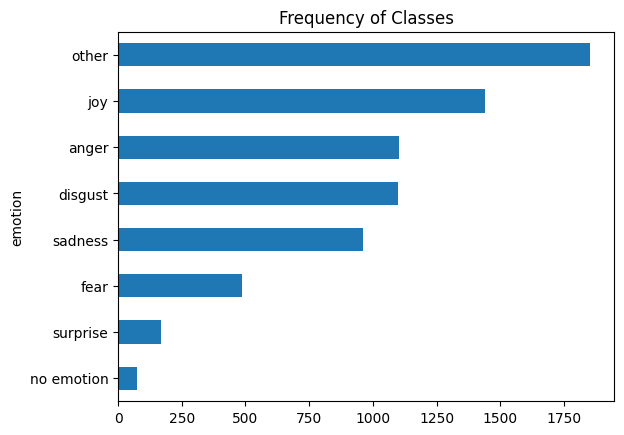

In [ ]:
import matplotlib.pyplot as plt

ait_en_test["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Definir el diccionario de emociones y las emociones disponibles
emolex_dict = {'anger': [], 'disgust': [], 'joy': [], 'fear': [], 'sadness': [], 'surprise': [], 'other':[]}
emotions = emolex_dict.keys()

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

def predict_emotion(tweet):
    pos_tagged_text = pos_tag(word_tokenize(tweet))
    word_count = len(pos_tagged_text)
    rows_list = []

    for word, tag in pos_tagged_text:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemma = lemmatizer.lemmatize(word, wntag) if wntag else word
        emo_score = emolex_words[emolex_words.word == lemma]
        if not emo_score.empty:
            rows_list.append(emo_score)

    if not rows_list:
        return "no emotion"

    df = pd.concat(rows_list)

    for emotion in emotions:
        emolex_dict[emotion] = df[emotion].sum() / word_count if emotion in df else 0

    # Tomar como etiqueta la emoción con el score más alto. Si todos los valores son 0, la etiqueta es "no emotion"
    predicted_emotion = max(emolex_dict, key=emolex_dict.get)
    if all(value == 0 for value in emolex_dict.values()):
        predicted_emotion = "no emotion"

    return predicted_emotion

# Aplicar la función a la columna de tweets y etiquetas
ait_en_test["predicted_emotion"] = ait_en_test["Tweet"].apply(predict_emotion)
ait_en_test.head(100)

,ID,Tweet,emotion,predicted_emotion
0,2018-En-01559,user user Dont worry Indian army is on its way...,anger,fear
1,2018-En-01559,user user Dont worry Indian army is on its way...,other,fear
2,2018-En-03739,"Academy of Sciences, eschews the normally sobe...",disgust,anger
3,2018-En-00385,I blew that opportunity -__- mad,anger,anger
4,2018-En-00385,I blew that opportunity -__- mad,disgust,anger
...,...,...,...,...
95,2018-En-00647,Comparing yourself to others is one of the roo...,sadness,sadness
96,2018-En-03390,user Hope your first shift back isn't too grim...,anger,fear
97,2018-En-03390,user Hope your first shift back isn't too grim...,other,fear
98,2018-En-01905,user user Americans do not spank their childre...,fear,anger


In [ ]:
from sklearn.metrics import classification_report

# Generar el informe de clasificación
print(classification_report(ait_en_test['emotion'], ait_en_test['predicted_emotion']))


              precision    recall  f1-score   support

       anger       0.27      0.43      0.33      1101
     disgust       0.26      0.06      0.10      1099
        fear       0.20      0.34      0.25       485
         joy       0.40      0.26      0.32      1442
  no emotion       0.03      0.36      0.05        75
       other       0.33      0.34      0.34      1854
     sadness       0.29      0.14      0.19       960
    surprise       0.04      0.02      0.03       170

    accuracy                           0.26      7186
   macro avg       0.23      0.24      0.20      7186
weighted avg       0.30      0.26      0.26      7186



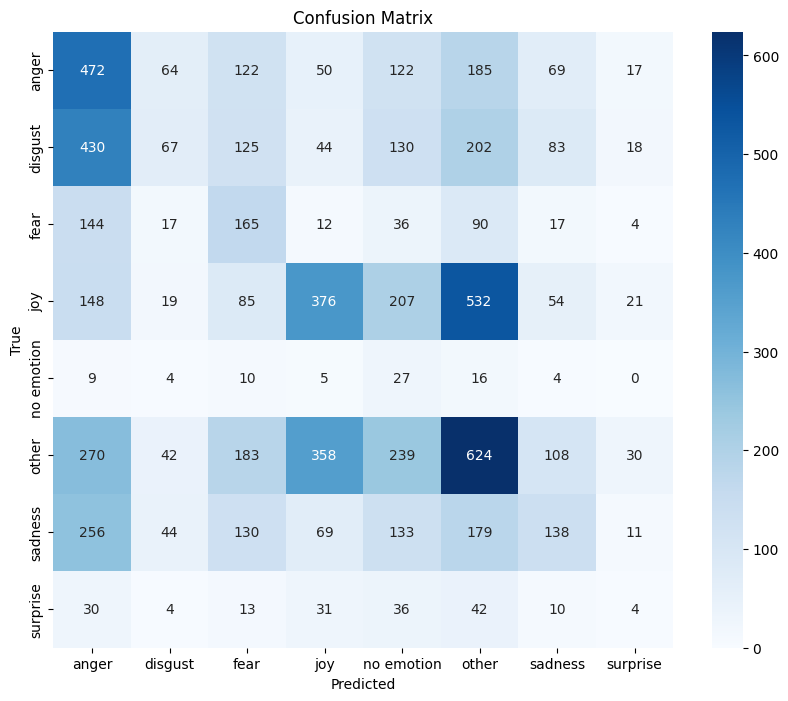

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(ait_en_test['emotion'], ait_en_test['predicted_emotion'])

# Definir las etiquetas de las clases (emociones)
classes = sorted(ait_en_test['emotion'].unique())

# Crear una visualización de la matriz de confusión usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **2.   MACHINE LEARNING**



## Enfoque con Naive Bayes Multinomial, Regresión logística y Ridge Classifier

## Preprocesamiento de los datos y preparación del entorno

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
import re
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Definir la función para preprocesar el texto de los tweets
def preprocess_tweet_text(text):
    if isinstance(text, str):
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\#','', text)
        text = re.sub(r'\@\w+','user', text)
    return text

# Especifica las rutas a los archivos CSV de los conjuntos de datos divididos
train_file = '/content/drive/My Drive/E-c_AIT-EN/ait_en_train.csv'
validation_file = '/content/drive/My Drive/E-c_AIT-EN/ait_en_dev.csv'
test_file = '/content/drive/My Drive/E-c_AIT-EN/ait_en_test.csv'

# Cargar los conjuntos de datos divididos en DataFrames de Pandas
df_train = pd.read_csv(train_file, delimiter=",")
df_validation = pd.read_csv(validation_file, delimiter=",")
df_test = pd.read_csv(test_file, delimiter=",")

# Aplicar preprocesamiento del texto a las columnas 'Tweet'
df_train['Tweet'] = df_train['Tweet'].apply(preprocess_tweet_text)
df_validation['Tweet'] = df_validation['Tweet'].apply(preprocess_tweet_text)
df_test['Tweet'] = df_test['Tweet'].apply(preprocess_tweet_text)


# Definir y ajustar el CountVectorizer en el conjunto de entrenamiento
cv = CountVectorizer()
X_train = cv.fit_transform(df_train['Tweet'])
X_valid = cv.transform(df_validation['Tweet'])
X_test = cv.transform(df_test['Tweet'])

# Obtener las etiquetas de las clases
y_train = df_train['emotion']
y_valid = df_validation['emotion']
y_test = df_test['emotion']

Mounted at /content/drive


## Entrenar y evaluar el modelo Multinomial Naive Bayes

### Definir el modelo, hiperparámetros y visualizar el informe de clasificación

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Definir el clasificador MNB
nb_clf = MultinomialNB()

# Definir los hiperparámetros a ajustar
param_grid_nb = {'alpha': [0.1, 1, 10]}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search_nb = GridSearchCV(nb_clf, param_grid_nb, cv=5, scoring='accuracy')
grid_search_nb.fit(X_train, y_train)

# Obtener el mejor estimador
best_nb_clf = grid_search_nb.best_estimator_

# Realizar predicciones con el mejor modelo en el conjunto de validación
y_pred_valid_nb = best_nb_clf.predict(X_valid)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters for MNB:", grid_search_nb.best_params_)

# Calcular la precisión en el conjunto de validación
val_score_nb = accuracy_score(y_valid, y_pred_valid_nb)
print("Validation accuracy (MNB):", val_score_nb)

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_test_nb = best_nb_clf.predict(X_test)

# Calcular la precisión en el conjunto de prueba
test_score_nb = accuracy_score(y_test, y_pred_test_nb)
print("Test accuracy (MNB):", test_score_nb)

# Reporte de clasificación
print("Classification report (MNB):")
print(classification_report(y_test, y_pred_test_nb))

Best hyperparameters for MNB: {'alpha': 1}
Validation accuracy (MNB): 0.32482124616956076
Test accuracy (MNB): 0.3266072919565822
Classification report (MNB):
              precision    recall  f1-score   support

       anger       0.32      0.31      0.31      1101
     disgust       0.27      0.29      0.28      1099
        fear       0.34      0.08      0.13       485
         joy       0.44      0.27      0.33      1442
  no emotion       0.00      0.00      0.00        75
       other       0.33      0.57      0.42      1854
     sadness       0.30      0.21      0.25       960
    surprise       0.00      0.00      0.00       170

    accuracy                           0.33      7186
   macro avg       0.25      0.22      0.21      7186
weighted avg       0.33      0.33      0.31      7186



### Visualizar la matriz de confusión

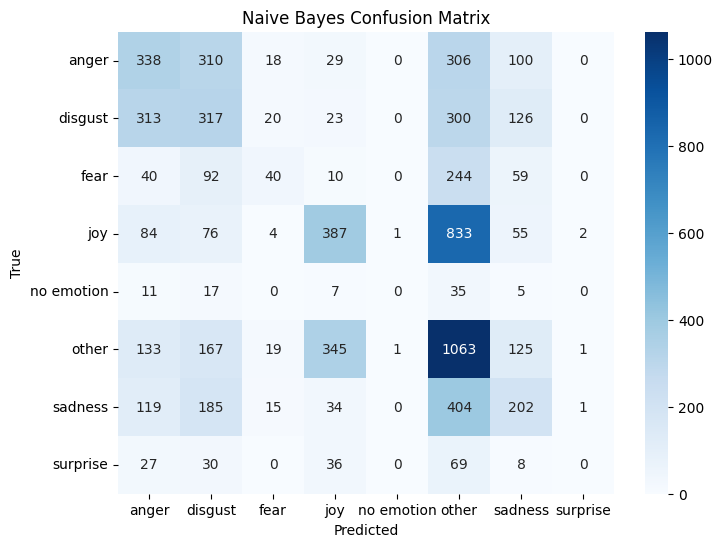

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
conf_matrix_nb = confusion_matrix(y_test, y_pred_test_nb)

# Visualización de la matriz de confusión
labels = sorted(df_test['emotion'].unique())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Entrenar y evaluar el modelo con Regresión Logística

### Definir el modelo y visualizar el informe de clasificación

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definir el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000)

# Definir la cuadrícula de hiperparámetros a buscar
param_grid_log_reg = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)

# Obtener el mejor estimador
best_log_reg = grid_search_log_reg.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred_log_reg = best_log_reg.predict(X_test)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters:", grid_search_log_reg.best_params_)

# Calcular la precisión en el conjunto de validación
val_score_log_reg = grid_search_log_reg.score(X_valid, y_valid)
print("Validation accuracy (Logistic Regression):", val_score_log_reg)

# Ajustar el mejor modelo nuevamente con el hiperparámetro encontrado
best_log_reg = LogisticRegression(C=grid_search_log_reg.best_params_['C'],
                                  solver=grid_search_log_reg.best_params_['solver'],
                                  max_iter=1000)
best_log_reg.fit(X_train, y_train)

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_log_reg = best_log_reg.predict(X_test)

# Calcular la precisión en el conjunto de prueba
test_score_log_reg = best_log_reg.score(X_test, y_test)
print("Test accuracy (Logistic Regression):", test_score_log_reg)

# Reporte de clasificación
print("Classification report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg))


Best hyperparameters: {'C': 0.1, 'solver': 'liblinear'}
Validation accuracy (Logistic Regression): 0.34014300306435136
Test accuracy (Logistic Regression): 0.335235179515725
Classification report (Logistic Regression):
              precision    recall  f1-score   support

       anger       0.35      0.30      0.33      1101
     disgust       0.27      0.26      0.27      1099
        fear       0.39      0.23      0.29       485
         joy       0.43      0.29      0.35      1442
  no emotion       0.00      0.00      0.00        75
       other       0.31      0.57      0.41      1854
     sadness       0.35      0.19      0.25       960
    surprise       0.20      0.01      0.01       170

    accuracy                           0.34      7186
   macro avg       0.29      0.23      0.24      7186
weighted avg       0.34      0.34      0.32      7186



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Visualizar la matriz de confusión

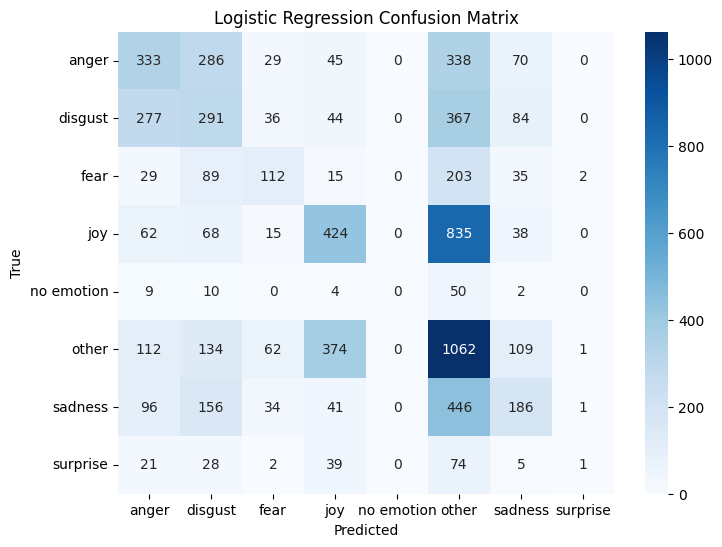

In [ ]:
# Matriz de confusión
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




## Entrenar y evaluar el modelo con el Clasificador Ridge

### Definir el modelo y visualizar el informe de clasificación

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Definir el clasificador Ridge
ridge_clf = RidgeClassifier()

# Definir los hiperparámetros a ajustar
param_grid_ridge = {'alpha': [0.1, 1, 10]}  # alpha es el parámetro de regularización

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(ridge_clf, param_grid_ridge, cv=5, scoring='accuracy')

# Realizar la búsqueda en cuadrícula y entrenar el modelo
grid_search.fit(X_train, y_train)

# Obtener el mejor estimador
best_ridge_clf = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_ridge = best_ridge_clf.predict(X_test)

# Imprimir los mejores hiperparámetros
print("Best hyperparameters:", grid_search.best_params_)

# Calcular la precisión en el conjunto de prueba
test_score_ridge = accuracy_score(y_test, y_pred_ridge)
print("Test accuracy (Ridge Classifier):", test_score_ridge)

# Validación cruzada para obtener la puntuación de validación
val_score = grid_search.score(X_valid, y_valid)
print("Validation accuracy:", val_score)

# Reporte de clasificación
print("Classification report (Ridge Classifier):")
print(classification_report(y_test, y_pred_ridge))



Best hyperparameters: {'alpha': 10}
Test accuracy (Ridge Classifier): 0.3424714723072641
Validation accuracy: 0.34167517875383047
Classification report (Ridge Classifier):
              precision    recall  f1-score   support

       anger       0.34      0.34      0.34      1101
     disgust       0.28      0.22      0.25      1099
        fear       0.38      0.38      0.38       485
         joy       0.41      0.38      0.39      1442
  no emotion       0.00      0.00      0.00        75
       other       0.32      0.46      0.38      1854
     sadness       0.34      0.27      0.30       960
    surprise       0.26      0.04      0.06       170

    accuracy                           0.34      7186
   macro avg       0.29      0.26      0.26      7186
weighted avg       0.34      0.34      0.33      7186



### Visualizar la matriz de confusión

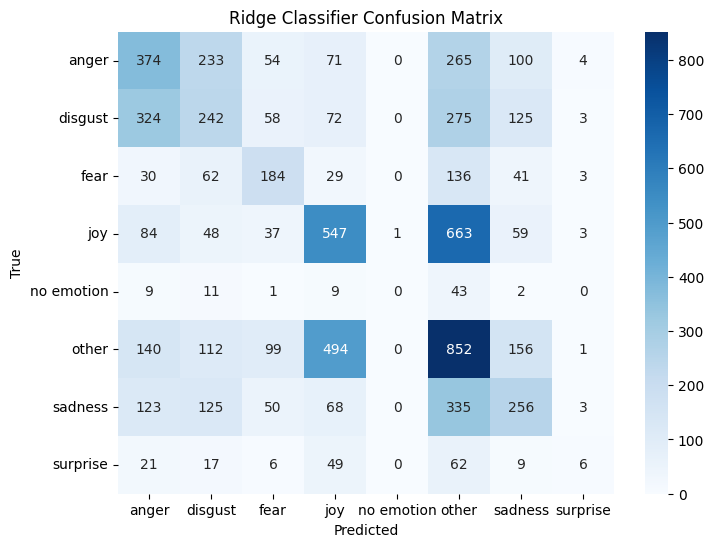

In [ ]:
# Matriz de confusión
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ridge, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Ridge Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Guardar los datos

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')


# Guardar los informes de clasificación individuales
# Multinomial Naive Bayes
clf_report_nb = classification_report(y_test, y_pred_test_nb, zero_division=0, output_dict=True)
df_results_nb = pd.DataFrame(clf_report_nb).transpose()

# Logistic Regression
clf_report_log_reg = classification_report(y_test, y_pred_log_reg, zero_division=0, output_dict=True)
df_results_log_reg = pd.DataFrame(clf_report_log_reg).transpose()

# Ridge Classifier
clf_report_ridge = classification_report(y_test, y_pred_ridge, zero_division=0, output_dict=True)
df_results_ridge = pd.DataFrame(clf_report_ridge).transpose()

# Concatenar los DataFrames de los informes de clasificación
df_classification_reports = pd.concat([df_results_nb, df_results_log_reg, df_results_ridge], axis=1)

# Crear una lista con los nombres de los modelos repetidos para cada grupo de columnas
model_names = ['Naive Bayes'] * len(df_results_nb.columns) + ['Logistic Regression'] * len(df_results_log_reg.columns) + ['Ridge Classifier'] * len(df_results_ridge.columns)

# Asignar los nombres de los modelos a cada columna
df_classification_reports.columns = [f'{model_name} - {col}' for model_name, col in zip(model_names, df_classification_reports.columns)]

# Insertar NaN en las columnas de 'precision' y 'recall' para la fila de 'accuracy'
df_classification_reports.loc['accuracy', df_classification_reports.columns.str.contains('precision')] = float('NaN')
df_classification_reports.loc['accuracy', df_classification_reports.columns.str.contains('recall')] = float('NaN')

# Guardar el DataFrame con los informes de clasificación en un archivo CSV
df_classification_reports.to_csv('/content/drive/MyDrive/E-c_AIT-EN/classification_reports_all_models.csv', index=True)

# Imprimir el DataFrame
print(df_classification_reports)

# Remover las columnas 'ID', 'Intensity Score' si están presentes
if 'ID' in df_test.columns or 'Intesity Score' in df_test.columns:
    df_test = df_test.drop(columns=[col for col in ['ID', 'Intensity Score'] if col in df_test.columns])

# Crear DataFrames separados para las predicciones de cada modelo y guardarlos
df_nb = df_test[['Tweet', 'emotion']].copy()
df_nb['predicted_emotion_nb'] = y_pred_test_nb
df_nb.to_csv('/content/drive/MyDrive/E-c_AIT-EN/predictions_naive_bayes.csv', index=False)

df_log_reg = df_test[['Tweet', 'emotion']].copy()
df_log_reg['predicted_emotion_log_reg'] = y_pred_log_reg
df_log_reg.to_csv('/content/drive/MyDrive/E-c_AIT-EN/predictions_logistic_regression.csv', index=False)

df_ridge = df_test[['Tweet', 'emotion']].copy()
df_ridge['predicted_emotion_ridge'] = y_pred_ridge
df_ridge.to_csv('/content/drive/MyDrive/E-c_AIT-EN/predictions_ridge.csv', index=False)

print("Todos los resultados y predicciones han sido guardados con éxito.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
              Naive Bayes - precision  Naive Bayes - recall  \
anger                        0.317371              0.306994   
disgust                      0.265494              0.288444   
fear                         0.344828              0.082474   
joy                          0.444317              0.268377   
no emotion                   0.000000              0.000000   
other                        0.326675              0.573355   
sadness                      0.297059              0.210417   
surprise                     0.000000              0.000000   
accuracy                          NaN                   NaN   
macro avg                    0.249468              0.216258   
weighted avg                 0.325631              0.326607   

              Naive Bayes - f1-score  Naive Bayes - support  \
anger                       0.312096            110

In [ ]:
df_classification_reports

,Naive Bayes - precision,Naive Bayes - recall,Naive Bayes - f1-score,Naive Bayes - support,Logistic Regression - precision,Logistic Regression - recall,Logistic Regression - f1-score,Logistic Regression - support,Ridge Classifier - precision,Ridge Classifier - recall,Ridge Classifier - f1-score,Ridge Classifier - support
anger,0.317371,0.306994,0.312096,1101.000000,0.354633,0.302452,0.326471,1101.000000,0.338462,0.339691,0.339075,1101.000000
disgust,0.265494,0.288444,0.276494,1099.000000,0.274011,0.264786,0.269320,1099.000000,0.284706,0.220200,0.248332,1099.000000
fear,0.344828,0.082474,0.133111,485.000000,0.386207,0.230928,0.289032,485.000000,0.376278,0.379381,0.377823,485.000000
joy,0.444317,0.268377,0.334630,1442.000000,0.430020,0.294036,0.349259,1442.000000,0.408514,0.379334,0.393384,1442.000000
no emotion,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000,0.000000,75.000000
other,0.326675,0.573355,0.416210,1854.000000,0.314667,0.572816,0.406196,1854.000000,0.323831,0.459547,0.379933,1854.000000
sadness,0.297059,0.210417,0.246341,960.000000,0.351607,0.193750,0.249832,960.000000,0.342246,0.266667,0.299766,960.000000
surprise,0.000000,0.000000,0.000000,170.000000,0.200000,0.005882,0.011429,170.000000,0.260870,0.035294,0.062176,170.000000
accuracy,NaN,NaN,0.326607,0.326607,NaN,NaN,0.335235,0.335235,NaN,NaN,0.342471,0.342471
macro avg,0.249468,0.216258,0.214860,7186.000000,0.288893,0.233081,0.237692,7186.000000,0.291863,0.260014,0.262561,7186.000000


In [ ]:
import pandas as pd

# Remover las columnas 'ID', 'Intensity Score' si están presentes
if 'ID' in df_test.columns or 'Intesity Score' in df_test.columns:
    df_test = df_test.drop(columns=[col for col in ['ID', 'Intensity Score'] if col in df_test.columns])

# Crear un DataFrame con todas las predicciones
df_all_predictions = df_test[['Tweet', 'emotion']].copy()
df_all_predictions['predicted_emotion_nb'] = y_pred_test_nb
df_all_predictions['predicted_emotion_log_reg'] = y_pred_log_reg
df_all_predictions['predicted_emotion_ridge'] = y_pred_ridge

# Guardar el DataFrame con todas las predicciones en un archivo CSV
df_all_predictions.to_csv('/content/drive/MyDrive/E-c_AIT-EN/ait_predictions_all_models.csv', index=False)

# Imprimir el DataFrame
print(df_all_predictions)

                                                  Tweet     emotion  \
0     user user Dont worry Indian army is on its way...       anger   
1     user user Dont worry Indian army is on its way...       other   
2     Academy of Sciences, eschews the normally sobe...     disgust   
3                      I blew that opportunity -__- mad       anger   
4                      I blew that opportunity -__- mad     disgust   
...                                                 ...         ...   
7181  user heard of Remothered? Indie horror game. W...       other   
7182        All this fake outrage. Y'all need to stop 🤣       anger   
7183        All this fake outrage. Y'all need to stop 🤣     disgust   
7184  Would be ever so grateful if you could record ...         joy   
7185  I'm the wholesome drunk that sends people meme...  no emotion   

     predicted_emotion_nb predicted_emotion_log_reg predicted_emotion_ridge  
0                 disgust                     other                  

In [ ]:
df_all_predictions

,Tweet,emotion,predicted_emotion_nb,predicted_emotion_log_reg,predicted_emotion_ridge
0,user user Dont worry Indian army is on its way...,anger,disgust,other,fear
1,user user Dont worry Indian army is on its way...,other,disgust,other,fear
2,"Academy of Sciences, eschews the normally sobe...",disgust,other,other,other
3,I blew that opportunity -__- mad,anger,other,other,anger
4,I blew that opportunity -__- mad,disgust,other,other,anger
...,...,...,...,...,...
7181,user heard of Remothered? Indie horror game. W...,other,other,other,other
7182,All this fake outrage. Y'all need to stop 🤣,anger,anger,anger,anger
7183,All this fake outrage. Y'all need to stop 🤣,disgust,anger,anger,anger
7184,Would be ever so grateful if you could record ...,joy,other,other,other


In [ ]:
import pandas as pd

# Supongamos que tienes tus datos originales y predicciones
original_texts = df_test['Tweet'].tolist()  # Textos originales
y_pred_test_nb = best_nb_clf.predict(X_test)  # Predicciones de Naive Bayes
y_pred_log_reg = best_log_reg.predict(X_test)  # Predicciones de Regresión Logística
y_pred_ridge = best_ridge_clf.predict(X_test)  # Predicciones de Clasificador Ridge
y_test = df_test['emotion'].tolist()  # Etiquetas verdaderas

# Crear un DataFrame con las emociones mal predichas y el nombre del LLM
misclassified_rows = []
for text, true_label, pred_nb, pred_log_reg, pred_ridge in zip(original_texts, y_test, y_pred_test_nb, y_pred_log_reg, y_pred_ridge):
    if true_label != pred_nb or true_label != pred_log_reg or true_label != pred_ridge:
        misclassified_rows.append({
            'Tweet': text,
            'true_label': true_label,
            'predicted_emotion_nb': pred_nb,
            'predicted_emotion_log_reg': pred_log_reg,
            'predicted_emotion_ridge': pred_ridge
        })

# Convertir la lista a un DataFrame
df_misclassified = pd.DataFrame(misclassified_rows)

# Guardar el DataFrame de emociones mal predichas en un archivo CSV si es necesario
df_misclassified.to_csv('/content/drive/MyDrive/E-c_AIT-EN/ait_misclassified_emotions_ML.csv', index=False)

# Mostrar el DataFrame de emociones mal predichas
print("Emociones mal predichas:")
df_misclassified

Emociones mal predichas:


,Tweet,true_label,predicted_emotion_nb,predicted_emotion_log_reg,predicted_emotion_ridge
0,user user Dont worry Indian army is on its way...,anger,disgust,other,fear
1,user user Dont worry Indian army is on its way...,other,disgust,other,fear
2,"Academy of Sciences, eschews the normally sobe...",disgust,other,other,other
3,I blew that opportunity -__- mad,anger,other,other,anger
4,I blew that opportunity -__- mad,disgust,other,other,anger
...,...,...,...,...,...
5777,user I've finished reading it; simply mind-blo...,sadness,other,sadness,sadness
5778,shaft abrasions from panties merely shifted to...,anger,other,other,other
5779,All this fake outrage. Y'all need to stop 🤣,disgust,anger,anger,anger
5780,Would be ever so grateful if you could record ...,joy,other,other,other


# **3.   DEEP LEARNING**



# Análisis, preprocesamiento y preparación de los datos

In [ ]:
#Cargamos los datasets

from google.colab import drive

drive.mount('/content/drive')
ait_train = '/content/drive/My Drive/E-c_AIT-EN/ait_en_train.csv'
ait_validation = '/content/drive/My Drive/E-c_AIT-EN/ait_en_dev.csv'
ait_test = '/content/drive/My Drive/E-c_AIT-EN/ait_en_test.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a concatenar todos los splits del dataset en un único dataframe, en el que creamos una columna especificando si el split es el dataset de entrenamiento, de validación o de evaluación.

In [ ]:
import pandas as pd

file_names = [(ait_train, "train"), (ait_validation, "validation"), (ait_test, "test")]

df_list = []

for file_name, split_name in file_names:
  df = pd.read_csv(file_name, delimiter=",")
  df["split"] = split_name
  df_list.append(df)

df = pd.concat(df_list)
df

,ID,Tweet,emotion,split
0,2017-En-21441,“Worry is a down payment on a problem you may ...,other,train
1,2017-En-31535,Whatever you decide to do make sure it makes y...,joy,train
2,2017-En-31535,Whatever you decide to do make sure it makes y...,other,train
3,2017-En-21068,@Max_Kellerman it also helps that the majorit...,anger,train
4,2017-En-21068,@Max_Kellerman it also helps that the majorit...,disgust,train
...,...,...,...,...
7181,2018-En-00416,@lomadia heard of Remothered? Indie horror gam...,other,test
7182,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,anger,test
7183,2018-En-03717,All this fake outrage. Y'all need to stop 🤣,disgust,test
7184,2018-En-03504,Would be ever so grateful if you could record ...,joy,test


In [ ]:
df = df[['Tweet', 'emotion', 'split']]
df

,Tweet,emotion,split
0,“Worry is a down payment on a problem you may ...,other,train
1,Whatever you decide to do make sure it makes y...,joy,train
2,Whatever you decide to do make sure it makes y...,other,train
3,@Max_Kellerman it also helps that the majorit...,anger,train
4,@Max_Kellerman it also helps that the majorit...,disgust,train
...,...,...,...
7181,@lomadia heard of Remothered? Indie horror gam...,other,test
7182,All this fake outrage. Y'all need to stop 🤣,anger,test
7183,All this fake outrage. Y'all need to stop 🤣,disgust,test
7184,Would be ever so grateful if you could record ...,joy,test


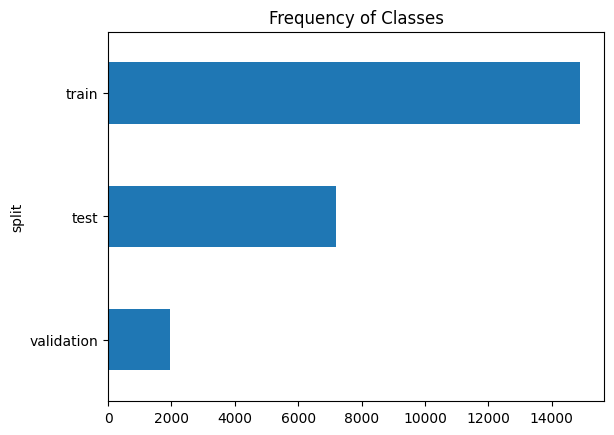

In [ ]:
# Distribución de instancias por split

import matplotlib.pyplot as plt

df["split"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

In [ ]:
# Preprocesamiento de los tweets
import re
def preprocess_tweet_text(tweet):
    # Quitar urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Quitar símbolo de hashtag '#'
    tweet = re.sub(r'\#','', tweet)
    # Reemplazar @xxx por user
    tweet = re.sub(r'\@\w+','user', tweet)
    return tweet
df['Tweet'] = df["Tweet"].apply(preprocess_tweet_text)
df

<ipython-input-19-2258bf2f8399>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tweet'] = df["Tweet"].apply(preprocess_tweet_text)


,Tweet,emotion,split
0,“Worry is a down payment on a problem you may ...,other,train
1,Whatever you decide to do make sure it makes y...,joy,train
2,Whatever you decide to do make sure it makes y...,other,train
3,user it also helps that the majority of NFL c...,anger,train
4,user it also helps that the majority of NFL c...,disgust,train
...,...,...,...
7181,user heard of Remothered? Indie horror game. W...,other,test
7182,All this fake outrage. Y'all need to stop 🤣,anger,test
7183,All this fake outrage. Y'all need to stop 🤣,disgust,test
7184,Would be ever so grateful if you could record ...,joy,test


Vamos a dividir nuevamente el dataframe en tres, uno por split.

In [ ]:
df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'validation']
df_test = df[df['split'] == 'test']

Debido a la naturaleza poco equilibrada de los datasets en cuanto al número de instancias por clase, vamos a aplicar lo que se conoce como *data augmentation*. Data augmentation es un proceso de generación de nuevos datos a partir de datos existentes, con el objetivo de mejorar el rendimiento de un modelo de aprendizaje automático. El proceso se lleva a cabo modificando ligeramente los datos existentes, utilizando técnicas específicas para cada tipo de dato (por ejemplo, rotando imágenes en el caso de imágenes, o modificando el orden de las palabras en el caso de texto). Al aumentar el tamaño del conjunto de datos de entrenamiento, se puede esperar que el modelo generalice mejor a datos no vistos durante el entrenamiento.

Para hacer data augmentation en categorías infrarepresentadas en el dataset de tweets, se pueden utilizar varias técnicas. Una opción es generar nuevos tweets a partir de los existentes, por ejemplo, cambiando palabras por sinónimos, cambiando el orden de las palabras o añadiendo palabras adicionales. También se pueden utilizar técnicas de traducción para obtener nuevos tweets en otro idioma y luego traducirlos al idioma original. Otro enfoque podría ser utilizar técnicas de aprendizaje automático para generar nuevos tweets a partir de un modelo entrenado en el dataset de tweets existente.

Nosotros vamos a hacer uso de la librería conocida como nlpaug. En particular, vamos utilizar uno de sus métodos para aplicar data augmentation a los tweets del conjunto de entrenamiento.

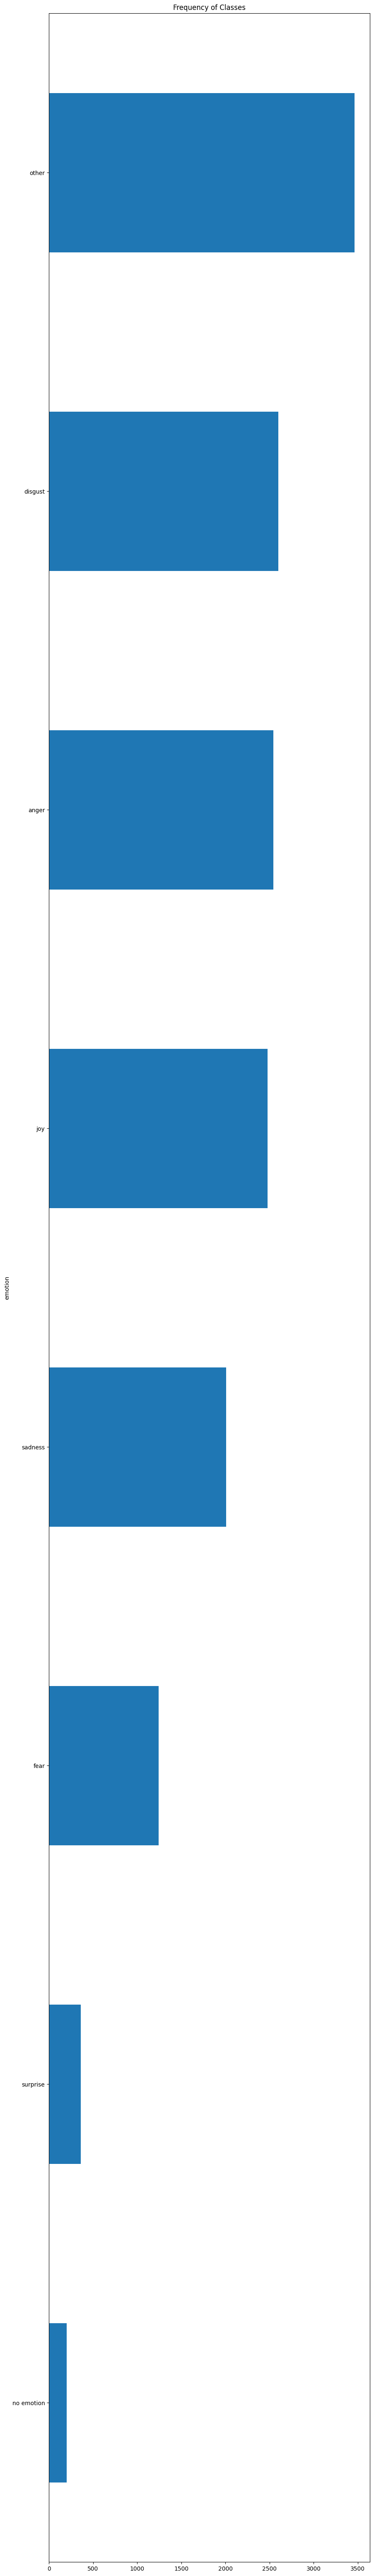

In [ ]:
# Distribucion de instancias por clases (i.e. emociones): dataset equilibrado

df_train["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.rcParams['figure.figsize'] = [10, 80]
plt.show()

Aleatorizamos los datasets.

In [ ]:
# Fijar semilla para reproducibilidad
import random
import numpy as np
import tensorflow as tf
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

df_train = df_train.sample(frac=1, random_state=RANDOM_SEED)
df_valid = df_valid.sample(frac=1, random_state=RANDOM_SEED)
df_test = df_test.sample(frac=1, random_state=RANDOM_SEED)

df_train

,Tweet,emotion,split
8694,user user all the best Moto GP is loosing a ve...,sadness,train
12235,The last few weeks have been dreadful. opening...,other,train
6702,don't give someone power by letting their word...,other,train
2357,Democracy doesn't work\n mob mentality mass hy...,disgust,train
6699,user looks exhilarating! Looking forward to se...,joy,train
...,...,...,...
5191,smh customers getting angry at me bc i aint go...,anger,train
13418,Imagine the twitter fume if Corbyn loses the e...,other,train
5390,"user haha, horrific is all that needs to be sa...",fear,train
860,user user But I decided to be a bit lackadaisi...,joy,train


In [ ]:
X_train = df_train['Tweet']
X_valid = df_valid['Tweet']
X_test = df_test['Tweet']

y_train = df_train['emotion']
y_valid = df_valid['emotion']
y_test = df_test['emotion']

X_train

8694     user user all the best Moto GP is loosing a ve...
12235    The last few weeks have been dreadful. opening...
6702     don't give someone power by letting their word...
2357     Democracy doesn't work\n mob mentality mass hy...
6699     user looks exhilarating! Looking forward to se...
                               ...                        
5191     smh customers getting angry at me bc i aint go...
13418    Imagine the twitter fume if Corbyn loses the e...
5390     user haha, horrific is all that needs to be sa...
860      user user But I decided to be a bit lackadaisi...
7270     Texans played horrible.  Bad play calling, bad...
Name: Tweet, Length: 14903, dtype: object

Vamos a realizar lo que se conoce como one-hot encoding, una técnica de preprocesamiento de datos que se utiliza a menudo en la creación de modelos de aprendizaje automático. Se utiliza para convertir variables categóricas, es decir, variables que solo pueden tomar un número limitado de valores discretos, como cadenas de texto, en formato numérico.

En este caso, se utiliza la clase LabelBinarizer de scikit-learn para realizar one-hot encoding en las etiquetas de entrenamiento, validación y prueba. Luego, se utilizan los métodos fit_transform y transform para ajustar el encoder a los datos de entrenamiento y luego transformar los datos de validación y prueba, respectivamente.

El método fit_transform ajusta el encoder a los datos de entrenamiento y luego realiza la transformación. El método transform, por otro lado, solo realiza la transformación utilizando el encoder ya ajustado.

Una vez que se han realizado los one-hot encoding, cada etiqueta se representa como un vector de ceros y unos, donde solo una posición del vector tiene un valor de uno y el resto tiene un valor de cero. Por ejemplo, si tenemos tres categorías, A, B y C, entonces la etiqueta A se representaría como [1, 0, 0], la etiqueta B como [0, 1, 0] y la etiqueta C como [0, 0, 1].

Una vez que se han realizado los one-hot encoding, se puede utilizar el conjunto de datos transformado para entrenar un modelo de redes neuronales con Keras.


In [ ]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

# Entrenamiento de redes neuronales

In [ ]:
!pip install keras
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


En estas líneas de código se está realizando el preprocesamiento de texto para poder utilizar los datos de texto en un modelo de redes neuronales.

Primero, se importa la clase Tokenizer de Keras. Esta clase proporciona una forma simple de preprocesar datos de texto para su uso en modelos de redes neuronales.

Luego, se crea una instancia de Tokenizer y se ajusta a los datos de entrenamiento con el método fit_on_texts. Esto construye un vocabulario de todas las palabras únicas en los datos de entrenamiento y asigna a cada palabra un índice entero único.

A continuación, se utiliza el método texts_to_sequences para convertir los datos de entrenamiento, validación y prueba en secuencias de índices de palabras. Cada palabra en el texto se reemplaza por el índice correspondiente del vocabulario construido anteriormente.

Una vez que se han convertido los datos de texto en secuencias de índices, se pueden utilizar como entrada para un modelo de redes neuronales. Sin embargo, tendremos que utilizar la función pad_sequences de Keras para asegurarnos de que todas las secuencias tengan la misma longitud antes de proporcionarlas como entrada al modelo.

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_valid= tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)
X_train

[[1, 1, 30, 2, 159, 8667, 5111, 7, 6641, 5, 191, 2777, 6642],
 [2,
  153,
  642,
  539,
  25,
  70,
  378,
  2543,
  34,
  8,
  207,
  2778,
  2,
  3531,
  8,
  568,
  952,
  13,
  8668,
  49,
  8669,
  860,
  909,
  8670],
 [37, 152, 118, 614, 46, 1288, 78, 505, 374, 9],
 [1947, 208, 127, 48, 4178, 3113, 2544, 2308, 3114, 3115],
 [1, 326, 485, 283, 628, 3, 486, 4179],
 [94, 128, 70, 19, 221, 173, 10, 11, 97, 559],
 [4, 655, 101, 115, 14, 11, 275, 71],
 [1, 1, 120, 41, 79, 1948, 28, 252],
 [17, 121, 24, 8671],
 [2309, 1289, 423],
 [1, 1, 1, 1, 1, 1, 1, 186, 162, 20, 6643, 146, 2, 175, 2, 175],
 [1,
  1,
  269,
  2,
  1493,
  1723,
  26,
  2,
  255,
  8,
  2,
  61,
  6,
  5112,
  311,
  30,
  80,
  702,
  8672],
 [137, 94, 18, 5, 147, 953, 122, 1416, 6644, 23, 1027, 27, 60],
 [4, 108, 73, 1832, 91, 14, 5113, 21, 338, 375, 7, 23, 114, 69, 362],
 [51,
  414,
  3,
  397,
  26,
  65,
  2779,
  92,
  767,
  2780,
  5,
  8673,
  57,
  51,
  4180,
  10,
  345,
  237,
  92,
  7,
  998],
 [1,
  

In [ ]:
# Inicializar la longitud máxima a 0
max_length = 0

# Recorrer cada elemento en X_train
for x in X_train:
    # Calcular la longitud del elemento actual
    length = len(x)

    # Actualizar la longitud máxima si la longitud actual es mayor
    if length > max_length:
        max_length = length

# Imprimir la longitud máxima encontrada
print("La longitud máxima es:", max_length)


La longitud máxima es: 35


In [ ]:
for x in X_train:
  if len(x)>34:
    print(len(x))


35
35
35


Estas líneas de código se utilizan para asegurar que todas las secuencias de texto tengan la misma longitud. Esto es necesario porque muchos modelos de redes neuronales requieren que la entrada tenga un tamaño fijo.

Primero, se calcula el tamaño del vocabulario a partir del objeto tokenizer creado anteriormente. Esto se hace sumando 1 al número de palabras únicas en el vocabulario, ya que el índice 0 se reserva para un token especial que se utiliza para rellenar las secuencias más cortas.

Luego, se establece la longitud máxima de las secuencias en 60. Esto significa que todas las secuencias se cortarán o rellenarán hasta tener una longitud de 60.

Finalmente, se utiliza la función pad_sequences de Keras para rellenar o cortar las secuencias de entrenamiento, validación y prueba hasta tener una longitud de 60. La opción padding='post' indica que el relleno se debe añadir al final de la secuencia. Si se elige padding='pre', el relleno se añadirá al principio de la secuencia.

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 35

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

X_train

array([[  1,   1,  30, ...,   0,   0,   0],
       [  2, 153, 642, ...,   0,   0,   0],
       [ 37, 152, 118, ...,   0,   0,   0],
       ...,
       [  1, 588, 465, ...,   0,   0,   0],
       [  1,   1,  21, ...,   0,   0,   0],
       [567, 726, 172, ...,   0,   0,   0]], dtype=int32)

In [ ]:
tokenizer.word_index

{'user': 1,
 'the': 2,
 'to': 3,
 'i': 4,
 'a': 5,
 'and': 6,
 'is': 7,
 'of': 8,
 'you': 9,
 'in': 10,
 'my': 11,
 'it': 12,
 'that': 13,
 'for': 14,
 'on': 15,
 'me': 16,
 'so': 17,
 'be': 18,
 'this': 19,
 'not': 20,
 'but': 21,
 'with': 22,
 'just': 23,
 "i'm": 24,
 'have': 25,
 'at': 26,
 'your': 27,
 'are': 28,
 'was': 29,
 'all': 30,
 'like': 31,
 "it's": 32,
 'when': 33,
 'up': 34,
 'if': 35,
 'amp': 36,
 "don't": 37,
 'about': 38,
 'get': 39,
 'no': 40,
 'what': 41,
 'will': 42,
 'can': 43,
 'we': 44,
 'out': 45,
 'by': 46,
 'do': 47,
 'n': 48,
 'from': 49,
 'he': 50,
 'they': 51,
 'as': 52,
 'an': 53,
 'or': 54,
 'people': 55,
 'how': 56,
 'now': 57,
 'one': 58,
 'know': 59,
 'time': 60,
 'day': 61,
 'his': 62,
 'love': 63,
 'u': 64,
 'her': 65,
 'happy': 66,
 'why': 67,
 'who': 68,
 'more': 69,
 'been': 70,
 'good': 71,
 "can't": 72,
 'really': 73,
 'see': 74,
 'am': 75,
 'has': 76,
 "'": 77,
 'their': 78,
 'some': 79,
 'still': 80,
 'got': 81,
 'being': 82,
 'go': 83,
 'mak

## Red neuronal de memoria a largo y corto plazo (LSTM)

La red LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente especialmente adecuada para procesar secuencias de datos.

La capa Embedding se encarga de convertir los textos en secuencias de enteros, donde cada entero representa una palabra en el vocabulario del modelo. Esta capa también especifica la dimensión del espacio vectorial en el que se representarán cada una de las palabras. La capa LSTM procesa esta secuencia de enteros y la capa Dense final realiza la clasificación.

In [ ]:
from keras.layers import LSTM

model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=300,
                    input_length=maxlen))

model.add(LSTM(128))
model.add(Dense(len(encoder.classes_), activation='softmax'))

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


La segunda línea de código se utiliza para compilar el modelo de redes neuronales definido previamente. Esto es necesario antes de poder entrenar el modelo o hacer predicciones con él.

La función compile toma tres argumentos:

    optimizer: es el optimizador que se utilizará para entrenar el modelo. El optimizador Adam es una buena opción por defecto para muchos problemas.
    loss: es la función de pérdida que se utilizará para medir el error del modelo durante el entrenamiento. La función de pérdida categorical_crossentropy se utiliza a menudo cuando se tienen varias clases y se utiliza la activación softmax en la capa de salida.
    metrics: es una lista con las métricas que se utilizarán para evaluar el modelo durante el entrenamiento y la validación. Normalmente, se utiliza la precisión (acc).

Vamos a utilizar como métrica el macro-F1. La métrica F1Score es una medida de rendimiento para problemas de clasificación y se basa en el equilibrio entre precisión y recall. Se puede calcular para cada clase por separado o para todas las clases juntas de forma promediada, como se está haciendo aquí con el parámetro "average='macro'".

La tercera línea de código se utiliza para imprimir un resumen del modelo. Esto incluye información sobre el número de capas, los tamaños de las capas y el número de parámetros entrenables del modelo. Esta información puede ser útil para depurar el modelo o para verificar que se ha definido correctamente.

In [ ]:
num_classes = len(encoder.classes_)
num_classes

8

In [ ]:
import tensorflow_addons as tfa
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=8, average='macro')])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           4111500   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
Total params: 4332180 (16.53 MB)
Trainable params: 4332180 (16.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


El resumen del modelo muestra la estructura de la red LSTM. Se puede ver que la capa Embedding tiene una salida de forma (None, 60, 300), lo que significa que para cada ejemplo de entrada, se generará una secuencia de 60 vectores de 300 dimensiones. La capa LSTM tiene una salida de forma (None, 128), lo que significa que para cada ejemplo de entrada, se generará un vector de 128 dimensiones. Por último, la capa Dense tiene una salida de forma (None, 8), lo que significa que para cada ejemplo de entrada, se generará un vector de 8 elementos que corresponden a las 8 clases posibles.

La función EarlyStopping de Keras se utiliza para detener el entrenamiento de un modelo cuando ya no se está mejorando en un conjunto de validación. Esto se hace para evitar el overfitting, es decir, que el modelo se ajuste demasiado a los datos de entrenamiento y tenga un rendimiento peor en los datos de validación o de prueba.

Los parámetros mode y restore_best_weights se utilizan para controlar el comportamiento del callback. El parámetro mode especifica qué medida se va a utilizar para determinar si el modelo está mejorando o no. Los valores válidos son 'auto', 'min' y 'max', y se refieren a si se quiere minimizar o maximizar la medida de pérdida o de metrica especificada en el parámetro monitor. Por ejemplo, si se está entrenando un modelo para clasificación y se quiere minimizar la pérdida categórica cruzada, se puede usar mode='min'.

El parámetro restore_best_weights indica si se quiere guardar el peso del modelo que obtuvo el mejor valor en el conjunto de validación y restaurarlo una vez que se detiene el entrenamiento. Si se establece en True, cuando se detiene el entrenamiento se restaurará el peso del modelo que obtuvo el mejor valor en el conjunto de validación. Si se establece en False, el modelo seguirá utilizando los pesos del último epoch de entrenamiento.

El parámetro "patience" se refiere al número de épocas que se deben esperar antes de detener el entrenamiento si no se observa una mejora en el valor de la métrica de evaluación. Por ejemplo, si se establece patience=2, entonces el entrenamiento se detendrá si no se observa una mejora en la métrica de evaluación durante 2 épocas consecutivas.

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=5)

La función fit de Keras se utiliza para entrenar un modelo a partir de datos de entrenamiento. Esta función toma varios argumentos:

    X_train: es una matriz de tamaño (num_ejemplos, longitud_secuencia) con los ejemplos de entrenamiento.
    y_train: es una matriz de tamaño (num_ejemplos, num_clases) con las etiquetas de clase correspondientes a los ejemplos de entrenamiento.
    batch_size: es el tamaño del batch de ejemplos que se utilizará para entrenar el modelo. El tamaño del batch influye en la velocidad de entrenamiento y en la precisión del modelo.
    epochs: es el número de veces que se iterará sobre los datos de entrenamiento.
    verbose: especifica cuánto detalle se muestra mientras se entrena el modelo. Si se establece en 1, se muestran las barras de progreso y una línea de resumen por cada epoch. Si se establece en 0, no se muestra ningún detalle.
    validation_data: es una tupla con los datos de validación y las etiquetas de clase correspondientes. Estos datos se utilizan para evaluar el modelo después de cada epoch y para detener el entrenamiento si no mejora.

La función fit devuelve un objeto history con información sobre el entrenamiento del modelo, como las pérdidas y las métricas de entrenamiento y validación en cada epoch. Esta información puede ser útil para evaluar el rendimiento del modelo y para ajustar sus hiperparámetros.

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
117/117 [==============================] - 111s 885ms/step - loss: 1.8847 - f1_score: 0.0663 - val_loss: 1.8283 - val_f1_score: 0.0500
Epoch 2/20
117/117 [==============================] - 61s 524ms/step - loss: 1.7863 - f1_score: 0.1285 - val_loss: 1.6445 - val_f1_score: 0.1475
Epoch 3/20
117/117 [==============================] - 41s 343ms/step - loss: 1.5962 - f1_score: 0.1932 - val_loss: 1.6404 - val_f1_score: 0.1694
Epoch 4/20
117/117 [==============================] - 40s 339ms/step - loss: 1.5075 - f1_score: 0.2290 - val_loss: 1.6114 - val_f1_score: 0.1694
Epoch 5/20
117/117 [==============================] - 40s 341ms/step - loss: 1.4297 - f1_score: 0.2669 - val_loss: 1.6310 - val_f1_score: 0.1537
Epoch 6/20
117/117 [==============================] - 37s 315ms/step - loss: 1.3493 - f1_score: 0.3279 - val_loss: 1.6157 - val_f1_score: 0.2448
Epoch 7/20
117/117 [==============================] - 37s 315ms/step - loss: 1.2885 - f1_score: 0.3727 - val_loss: 1.6589 - val_f

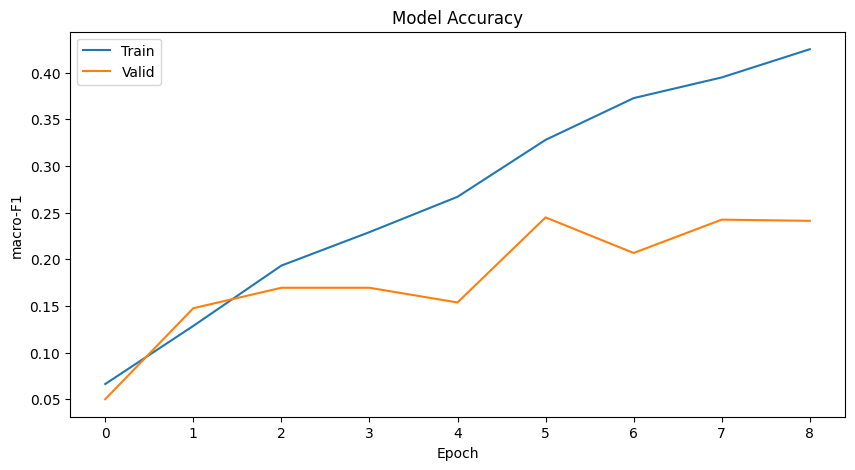

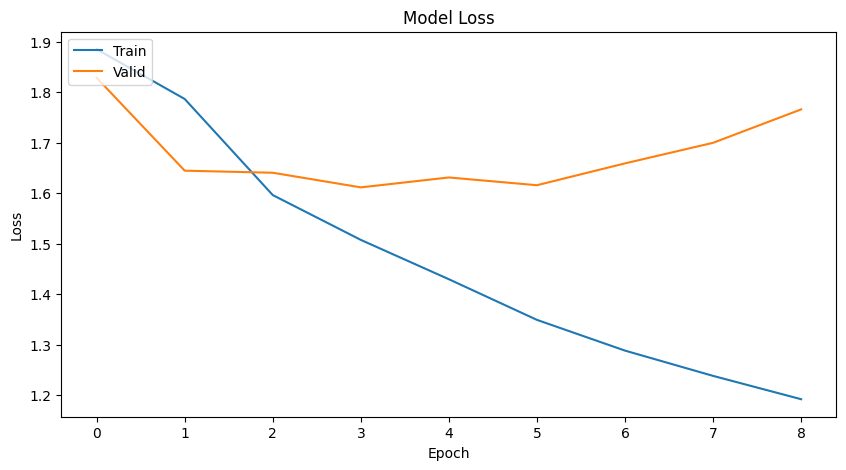

In [ ]:
import matplotlib.pyplot as plt

# Ajustar el tamaño de la gráfica de accuracy
plt.figure(figsize=(10, 5))  # Cambia (10, 5) por las dimensiones deseadas
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model Accuracy')
plt.ylabel('macro-F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Ajustar el tamaño de la gráfica de loss
plt.figure(figsize=(10, 5))  # Cambia (10, 5) por las dimensiones deseadas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


La función evaluate de Keras se utiliza para evaluar un modelo en datos de test. Esta función toma tres argumentos:

    X_test: es una matriz de tamaño (num_ejemplos, longitud_secuencia) con los ejemplos de test.
    y_test: es una matriz de tamaño (num_ejemplos, num_clases) con las etiquetas de clase correspondientes a los ejemplos de test.
    verbose: especifica cuánto detalle se muestra mientras se evalúa el modelo. Si se establece en 1, se muestra una barra de progreso y una línea de resumen al final. Si se establece en 0, no se muestra ningún detalle.

La función evaluate devuelve una lista con dos elementos: la pérdida y la métrica de evaluación del modelo en los datos de test. En este caso, la métrica de evaluación es el macro-F1.

La variable score tendrá una lista con la pérdida y el macro-F1 del modelo aplicado al dataset de evaluación. Esta información puede ser útil para evaluar el rendimiento del modelo y compararlo con otros modelos.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

225/225 [==============================] - 1s 3ms/step - loss: 1.6240 - f1_score: 0.1659


In [ ]:
print("Test Score:", score[0])
print("Test Macro-F1:", score[1])

Test Score: 1.6240266561508179
Test Macro-F1: 0.16589875519275665


La primera línea de código importa la función classification_report de scikit-learn, que se utiliza para generar un informe de clasificación a partir de las etiquetas de clase de verdad y de las predicciones del modelo.

La segunda línea importa la librería numpy.

Luego, se utiliza la función predict del modelo para generar predicciones en el test dataset. Las predicciones son una matriz de tamaño (num_ejemplos, num_clases) con las probabilidades de pertenencia a cada clase.

A continuación, se convierten las predicciones en etiquetas de clase utilizando la función argmax de numpy. La función argmax devuelve el índice del elemento máximo en cada fila de la matriz. Al especificar axis=1, se aplica la función a cada fila en lugar de a cada columna.

Luego, se convierten las etiquetas de clase del conjunto de evaluación en etiquetas de clase utilizando la función argmax de la misma manera.

Por último, se utiliza la función classification_report de scikit-learn para generar un informe de clasificación a partir de las etiquetas de clase del conjunto de test y de las predicciones del modelo.

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

225/225 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       anger       0.34      0.44      0.38      1101
     disgust       0.24      0.18      0.21      1099
        fear       0.27      0.16      0.20       485
         joy       0.50      0.00      0.00      1442
  no emotion       0.00      0.00      0.00        75
       other       0.33      0.78      0.47      1854
     sadness       0.21      0.05      0.07       960
    surprise       0.00      0.00      0.00       170

    accuracy                           0.31      7186
   macro avg       0.23      0.20      0.17      7186
weighted avg       0.32      0.31      0.23      7186



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_LSTM'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_LSTM']]

# Mostrar los ejemplos erróneos
errores[['Tweet', 'emotion', 'prediction_LSTM']]

225/225 [==============================] - 1s 3ms/step


,Tweet,emotion,prediction_LSTM
7023,Sad sentiment does a bad mind-management as wo...,sadness,other
4908,When being productive (doing the things that N...,joy,other
6108,"'I smile. I laugh. \nBut behind it, is a myste...",surprise,other
1894,user well be offended then cause im speakin tr...,anger,other
3066,"Hateful , horrible , horrendous ... = last nig...",anger,fear
...,...,...,...
3772,1 Samuel 18:15\nAnd when Saul saw that he had ...,joy,other
5191,The only thing more shocking than the truth ar...,disgust,anger
5226,user lol the clapper is upside frown,disgust,other
5390,user I don't even read the news anymore is to ...,sadness,disgust


### LSTM con Dropout

Una forma de crear una LSTM más compleja es añadiendo más capas LSTM a la red. También podemos añadir una capa de Dropout para evitar el sobreajuste, y probar diferentes tamaños de ventana y diferentes tasas de Dropout. Además, podemos probar diferentes optimizadores y valores de aprendizaje inicial. Con esta red LSTM se han añadido dos capas LSTM y dos capas de dropout para evitar el sobreajuste. Además, se ha establecido la opción return_sequences=True en la primera capa LSTM para que devuelva las secuencias de salida en lugar de solo la última salida para poder aplicar la capa de dropout a todas las salidas de la primera capa LSTM.

In [ ]:
from keras.layers import LSTM, Dropout

model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
output_dim=300,
input_length=maxlen))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=8, average='macro')])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 300)           4111500   
                                                                 
 lstm_1 (LSTM)               (None, 35, 128)           219648    
                                                                 
 dropout (Dropout)           (None, 35, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 4463764 (17.03 MB)
Trainable params: 446

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
117/117 [==============================] - 57s 429ms/step - loss: 1.9031 - f1_score: 0.0954 - val_loss: 1.8312 - val_f1_score: 0.0500
Epoch 2/20
117/117 [==============================] - 42s 360ms/step - loss: 1.7151 - f1_score: 0.1712 - val_loss: 1.6370 - val_f1_score: 0.1432
Epoch 3/20
117/117 [==============================] - 39s 333ms/step - loss: 1.5742 - f1_score: 0.2024 - val_loss: 1.6281 - val_f1_score: 0.1665
Epoch 4/20
117/117 [==============================] - 38s 329ms/step - loss: 1.4904 - f1_score: 0.2659 - val_loss: 1.6124 - val_f1_score: 0.1774
Epoch 5/20
117/117 [==============================] - 37s 320ms/step - loss: 1.4224 - f1_score: 0.3057 - val_loss: 1.5933 - val_f1_score: 0.2213
Epoch 6/20
117/117 [==============================] - 36s 311ms/step - loss: 1.3463 - f1_score: 0.3440 - val_loss: 1.6119 - val_f1_score: 0.2500
Epoch 7/20
117/117 [==============================] - 36s 309ms/step - loss: 1.2920 - f1_score: 0.3962 - val_loss: 1.6529 - val_f1

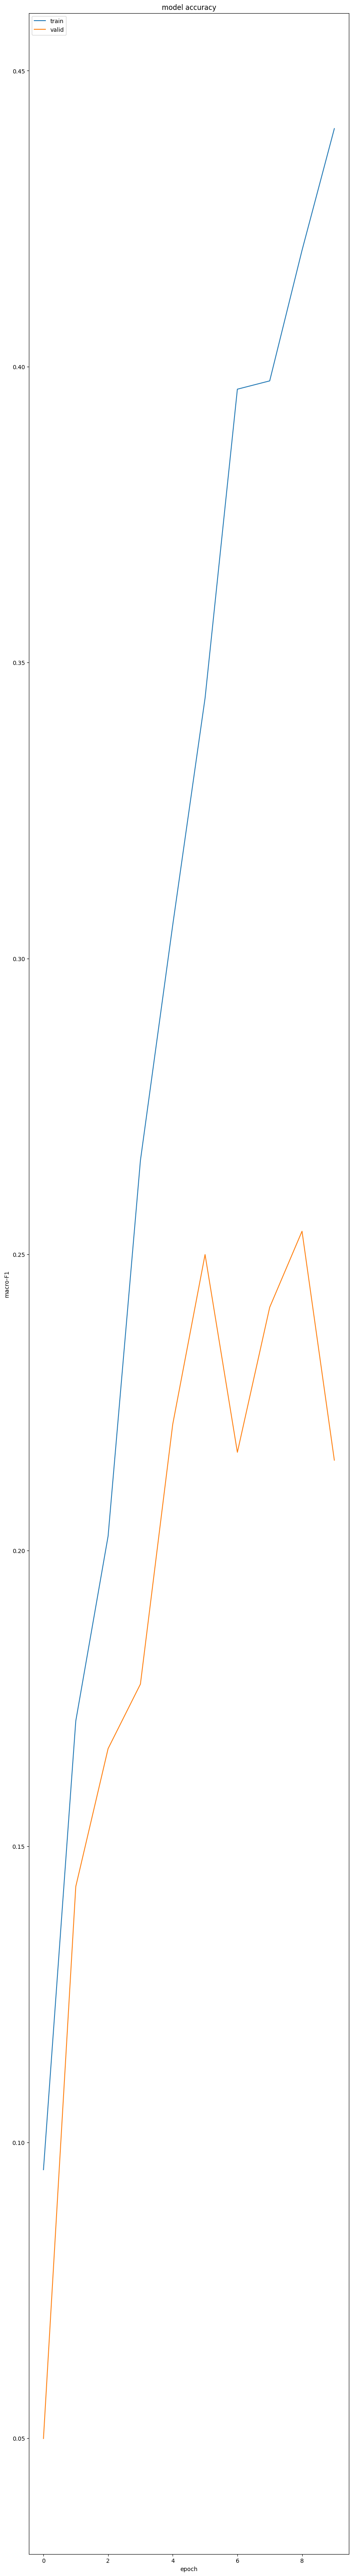

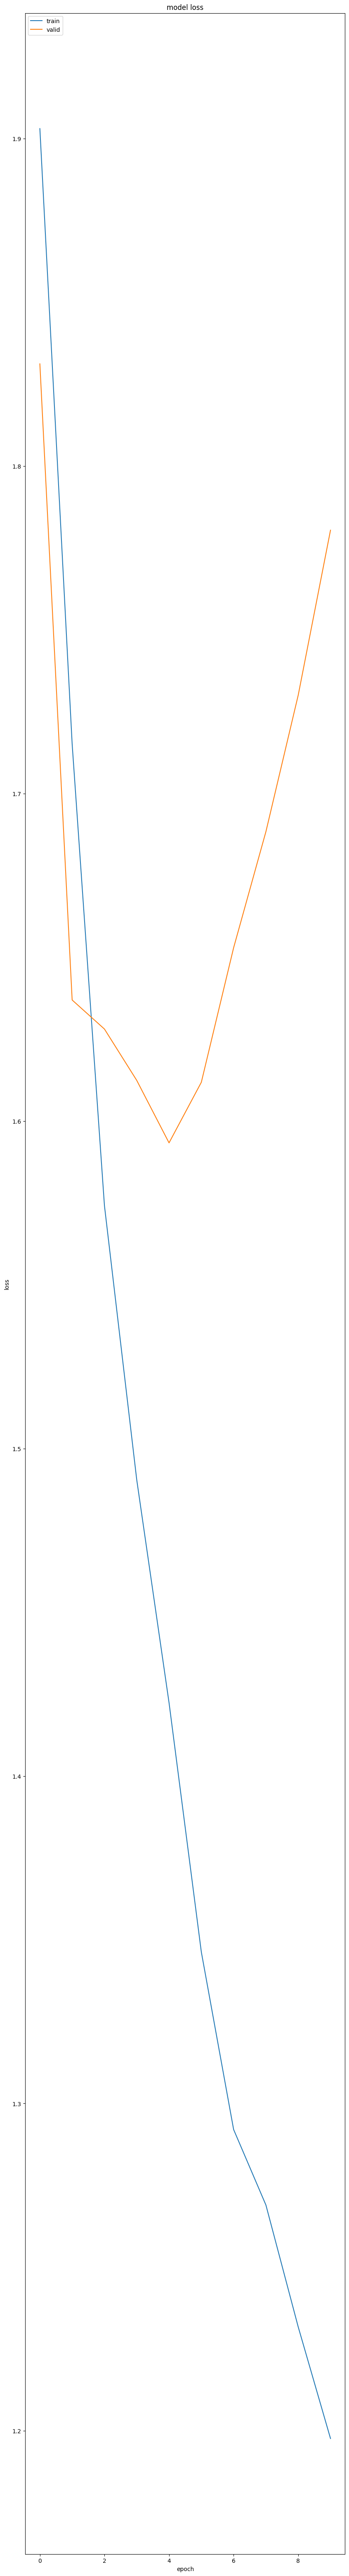

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

225/225 [==============================] - 1s 6ms/step - loss: 1.6096 - f1_score: 0.2171


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

225/225 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

       anger       0.33      0.50      0.40      1101
     disgust       0.23      0.10      0.14      1099
        fear       0.34      0.18      0.24       485
         joy       0.44      0.48      0.46      1442
  no emotion       0.12      0.01      0.02        75
       other       0.29      0.44      0.35      1854
     sadness       0.21      0.10      0.14       960
    surprise       0.00      0.00      0.00       170

    accuracy                           0.33      7186
   macro avg       0.25      0.23      0.22      7186
weighted avg       0.30      0.33      0.30      7186



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_LSTM_Dropout'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_LSTM_Dropout']]

# Mostrar los ejemplos erróneos
errores[['Tweet', 'emotion', 'prediction_LSTM_Dropout']]

225/225 [==============================] - 1s 4ms/step


,Tweet,emotion,prediction_LSTM_Dropout
1315,"user ooh, how I'd dance with glee around the l...",other,joy
1893,Does anybody mom annoy them just by talking an...,disgust,other
7023,Sad sentiment does a bad mind-management as wo...,sadness,other
4908,When being productive (doing the things that N...,joy,fear
6108,"'I smile. I laugh. \nBut behind it, is a myste...",surprise,joy
...,...,...,...
3772,1 Samuel 18:15\nAnd when Saul saw that he had ...,joy,fear
5191,The only thing more shocking than the truth ar...,disgust,anger
5226,user lol the clapper is upside frown,disgust,other
5390,user I don't even read the news anymore is to ...,sadness,other


## Red neuronal convolutiva (CNN)

Vamos a utilizar ahora una red neuronal convolutiva (CNN, por sus siglas en inglés), un tipo especial de red neuronal que se utiliza a menudo para procesar datos con una estructura espacial, como imágenes. Una CNN tiene capas de "convolución" que realizan operaciones de filtrado en la entrada para extraer características específicas.

Estas líneas de código implementan un modelo de CNN para procesar texto. La primera capa es una capa de embeddings, que se encarga de convertir cada palabra del texto en un vector de embeddings. Esta capa es seguida por una capa de convolución 1D, que realiza operaciones de filtrado en las secuencias de embeddings para extraer características específicas. La capa de convolución tiene 128 filtros de tamaño 5, y utiliza la función de activación ReLU para aplicar una no-linealidad.

Después de la capa de convolución, se añade una capa de pooling global, que se encarga de reducir la dimensionalidad de las características extraídas por la capa de convolución. En este caso se utiliza pooling global, que se aplica a todas las secuencias de la salida de la capa de convolución y devuelve el máximo valor de cada uno de los filtros.

Por último, se añade una capa densa final con la misma cantidad de unidades que clases de salida y con la función de activación softmax. La función softmax devuelve una distribución de probabilidad sobre las clases de salida, lo que permite interpretar la salida de la red como la probabilidad de que pertenezca a cada clase.

In [ ]:
from keras.layers import Conv1D
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=300,
                    input_length=maxlen))

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(len(encoder.classes_), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=8, average='macro')])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 300)           4111500   
                                                                 
 conv1d (Conv1D)             (None, 31, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 4304660 (16.42 MB)
Trainable params: 4304660 (16.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/20
117/117 [==============================] - 52s 430ms/step - loss: 1.8450 - f1_score: 0.0964 - val_loss: 1.6535 - val_f1_score: 0.1735
Epoch 2/20
117/117 [==============================] - 41s 352ms/step - loss: 1.5526 - f1_score: 0.2270 - val_loss: 1.5393 - val_f1_score: 0.2254
Epoch 3/20
117/117 [==============================] - 39s 333ms/step - loss: 1.4064 - f1_score: 0.2635 - val_loss: 1.5205 - val_f1_score: 0.2483
Epoch 4/20
117/117 [==============================] - 39s 330ms/step - loss: 1.3253 - f1_score: 0.2728 - val_loss: 1.5472 - val_f1_score: 0.2220
Epoch 5/20
117/117 [==============================] - 37s 317ms/step - loss: 1.2596 - f1_score: 0.3471 - val_loss: 1.5492 - val_f1_score: 0.2573
Epoch 6/20
117/117 [==============================] - 36s 306ms/step - loss: 1.2110 - f1_score: 0.3823 - val_loss: 1.5538 - val_f1_score: 0.2748
Epoch 7/20
117/117 [==============================] - 36s 306ms/step - loss: 1.1799 - f1_score: 0.3919 - val_loss: 1.5541 - val_f1

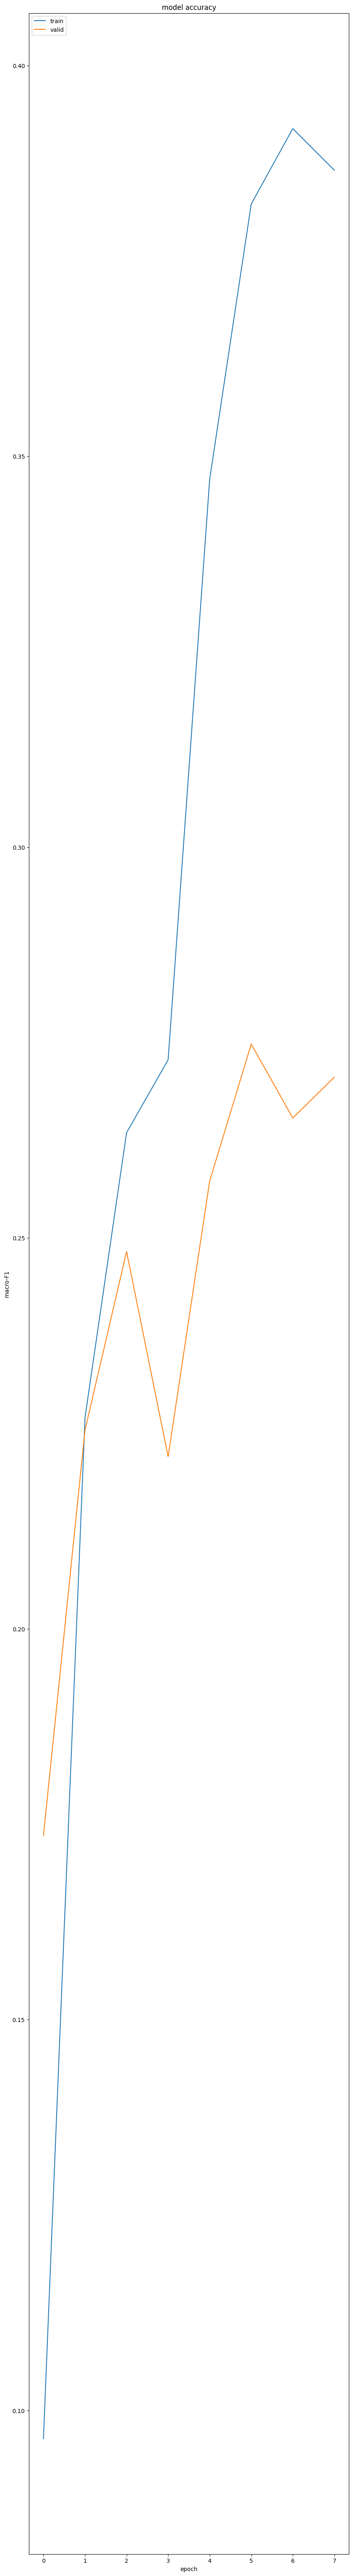

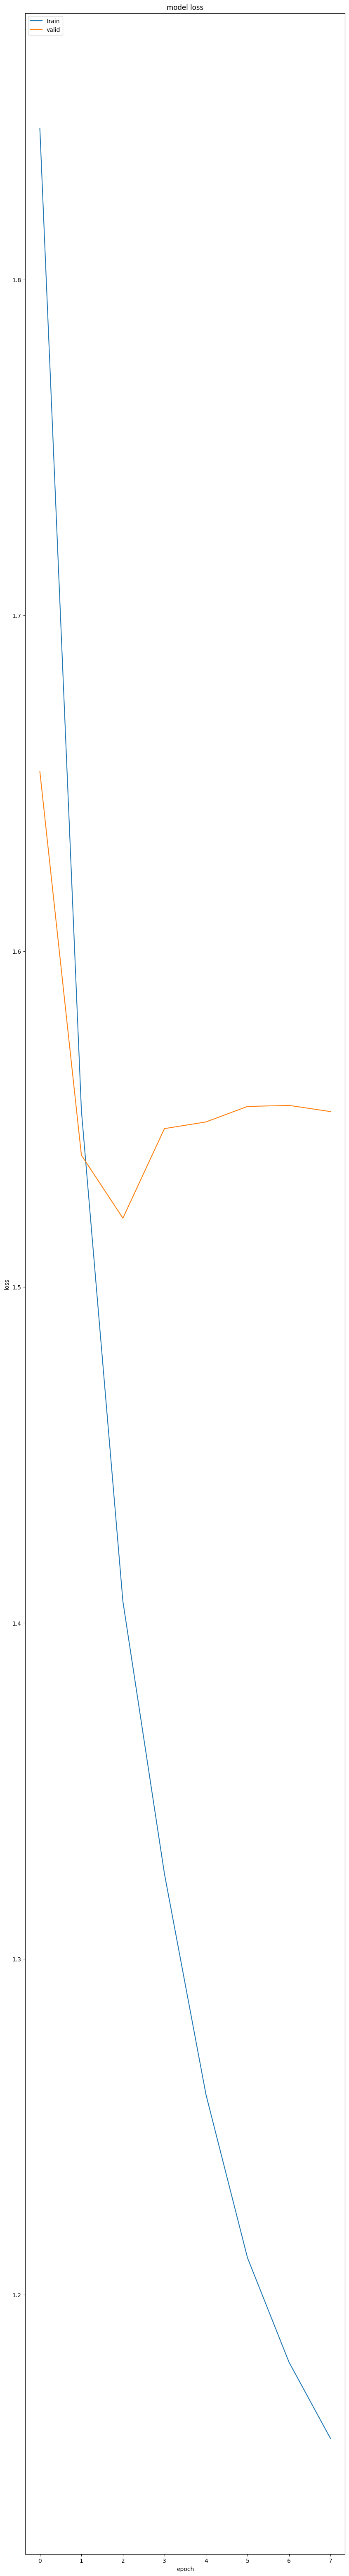

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

225/225 [==============================] - 1s 4ms/step - loss: 1.5475 - f1_score: 0.2481


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

225/225 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       0.34      0.50      0.40      1101
     disgust       0.28      0.10      0.15      1099
        fear       0.39      0.30      0.34       485
         joy       0.46      0.41      0.43      1442
  no emotion       0.00      0.00      0.00        75
       other       0.31      0.49      0.38      1854
     sadness       0.37      0.22      0.27       960
    surprise       0.14      0.01      0.01       170

    accuracy                           0.35      7186
   macro avg       0.29      0.25      0.25      7186
weighted avg       0.35      0.35      0.33      7186



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_CNN'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_CNN']]

# Mostrar los ejemplos erróneos
errores[['Tweet', 'emotion', 'prediction_CNN']]

225/225 [==============================] - 0s 2ms/step


,Tweet,emotion,prediction_CNN
1893,Does anybody mom annoy them just by talking an...,disgust,other
7023,Sad sentiment does a bad mind-management as wo...,sadness,other
4908,When being productive (doing the things that N...,joy,fear
6108,"'I smile. I laugh. \nBut behind it, is a myste...",surprise,joy
1894,user well be offended then cause im speakin tr...,anger,sadness
...,...,...,...
3092,Having fun today at Mad museum Stratford upon ...,joy,anger
3772,1 Samuel 18:15\nAnd when Saul saw that he had ...,joy,other
5191,The only thing more shocking than the truth ar...,disgust,anger
5226,user lol the clapper is upside frown,disgust,joy


### CNN con dos capas

Este modelo implementa una red neuronal convolucional (CNN) con dos capas de filtro de tamaño 5 y 3, respectivamente, que se aplican sobre la entrada de datos, que es una secuencia de vectores de embedding de palabras. Después de aplicar estos filtros, se aplica una capa de pooling global, que toma el máximo valor de cada filtro y lo reduce a un vector unidimensional. Luego, hay dos capas densas, una con 64 unidades y la otra con el número de clases en el dataset (7 en este caso). La primera capa densa tiene una función de activación ReLU y la segunda tiene una función de activación softmax. Además, hay una capa de dropout con tasa de 0.5 para prevenir overfitting. Finalmente, se compila el modelo con la función de pérdida categorical crossentropy y la métrica F1 con una media macro.

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=300,
                    input_length=maxlen))

model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=8, average='macro')])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 300)           4111500   
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 128)           192128    
                                                                 
 conv1d_2 (Conv1D)           (None, 29, 64)            24640     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/10
117/117 [==============================] - 53s 437ms/step - loss: 1.9338 - f1_score: 0.1204 - val_loss: 1.7926 - val_f1_score: 0.0500
Epoch 2/10
117/117 [==============================] - 42s 362ms/step - loss: 1.7458 - f1_score: 0.1691 - val_loss: 1.6572 - val_f1_score: 0.1677
Epoch 3/10
117/117 [==============================] - 39s 332ms/step - loss: 1.5951 - f1_score: 0.2063 - val_loss: 1.6019 - val_f1_score: 0.1966
Epoch 4/10
117/117 [==============================] - 38s 328ms/step - loss: 1.5012 - f1_score: 0.2434 - val_loss: 1.5854 - val_f1_score: 0.2206
Epoch 5/10
117/117 [==============================] - 37s 319ms/step - loss: 1.4301 - f1_score: 0.2624 - val_loss: 1.6012 - val_f1_score: 0.2420
Epoch 6/10
117/117 [==============================] - 36s 309ms/step - loss: 1.3678 - f1_score: 0.2727 - val_loss: 1.6006 - val_f1_score: 0.2574
Epoch 7/10
117/117 [==============================] - 36s 308ms/step - loss: 1.3137 - f1_score: 0.3306 - val_loss: 1.6393 - val_f1

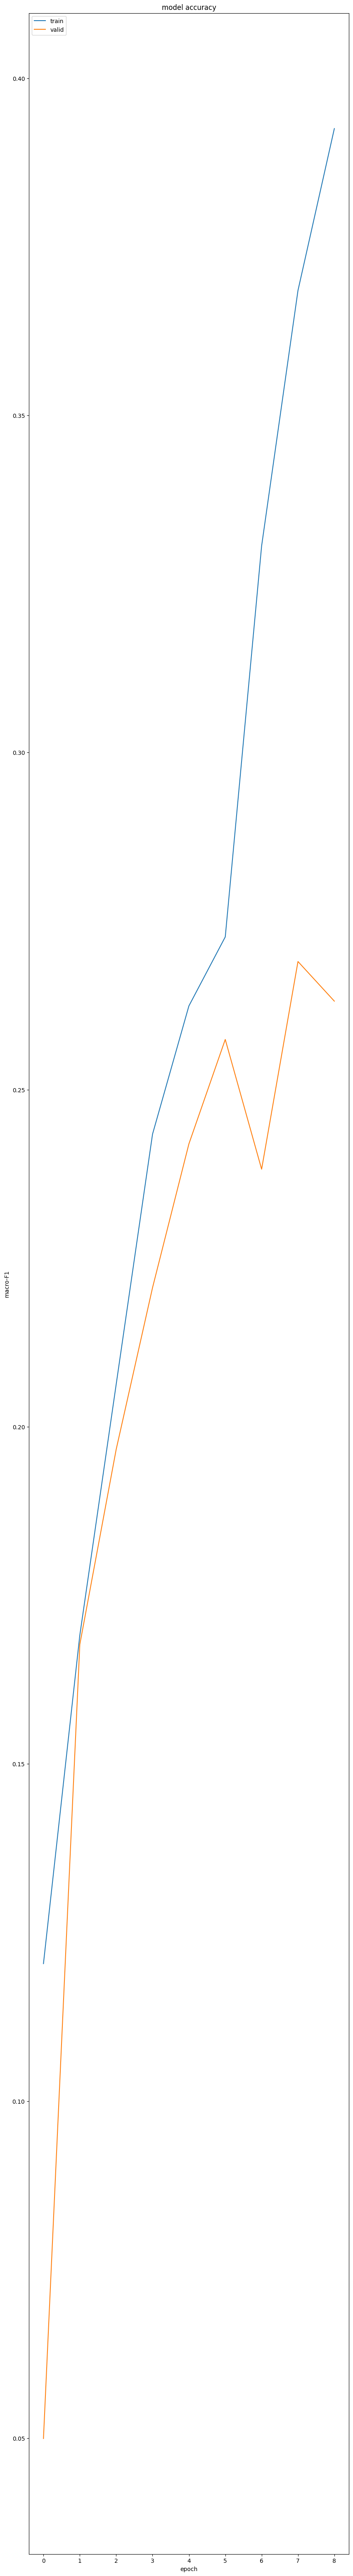

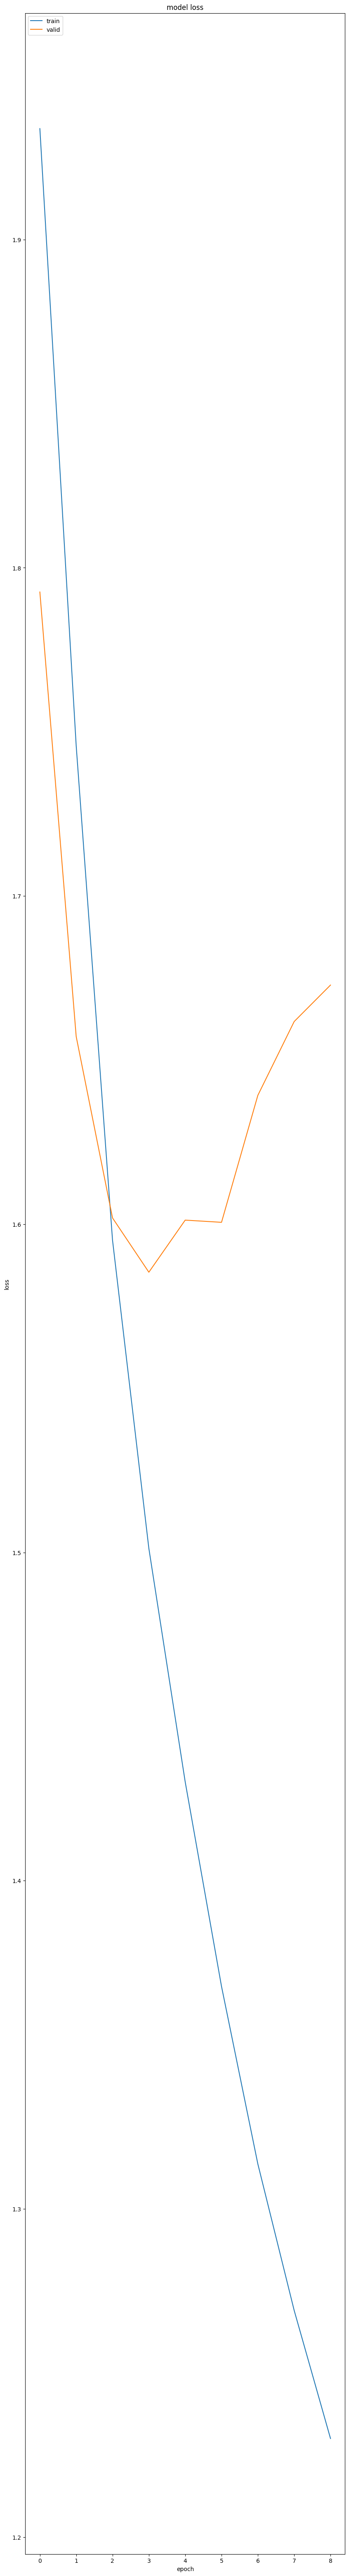

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model accuracy')
plt.ylabel('macro-F1')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

225/225 [==============================] - 1s 3ms/step - loss: 1.6068 - f1_score: 0.2208


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Generamos predicciones en test dataset
predictions = model.predict(X_test)

# Convertimos predicciones en las etiquetas
predictions = np.argmax(predictions, axis=1)

# Convertimos el vector one hot encoding en las etiquetas de clase
y_test_labels = np.argmax(y_test, axis=1)

# Generamos informe de clasificación
report = classification_report(y_test_labels, predictions, target_names=encoder.classes_)
print(report)

225/225 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

       anger       0.31      0.59      0.41      1101
     disgust       0.21      0.07      0.11      1099
        fear       0.36      0.28      0.31       485
         joy       0.45      0.42      0.43      1442
  no emotion       0.00      0.00      0.00        75
       other       0.30      0.45      0.36      1854
     sadness       0.40      0.09      0.14       960
    surprise       0.00      0.00      0.00       170

    accuracy                           0.33      7186
   macro avg       0.25      0.24      0.22      7186
weighted avg       0.32      0.33      0.30      7186



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

# Generar predicciones en el conjunto de prueba
predictions = model.predict(X_test)

# Convertir las predicciones en etiquetas de clase (índices de clases)
predicted_labels = np.argmax(predictions, axis=1)

# Agregar las predicciones al DataFrame df_test
df_test['prediction_CNN_2L'] = encoder.classes_[predicted_labels]

# Filtrar los ejemplos donde la predicción no coincide con la etiqueta real
errores = df_test[df_test['emotion'] != df_test['prediction_CNN_2L']]

# Mostrar los ejemplos erróneos
errores[['Tweet', 'emotion', 'prediction_CNN_2L']]

225/225 [==============================] - 1s 3ms/step


,Tweet,emotion,prediction_CNN_2L
1893,Does anybody mom annoy them just by talking an...,disgust,other
7023,Sad sentiment does a bad mind-management as wo...,sadness,other
4908,When being productive (doing the things that N...,joy,fear
6108,"'I smile. I laugh. \nBut behind it, is a myste...",surprise,other
1894,user well be offended then cause im speakin tr...,anger,other
...,...,...,...
3772,1 Samuel 18:15\nAnd when Saul saw that he had ...,joy,other
5191,The only thing more shocking than the truth ar...,disgust,anger
5226,user lol the clapper is upside frown,disgust,other
5390,user I don't even read the news anymore is to ...,sadness,disgust


## Visualización de los datos

In [ ]:
# Seleccionar las columnas en el orden deseado
errors = df_test[['Tweet', 'emotion', 'prediction_LSTM', 'prediction_LSTM_Dropout', 'prediction_CNN','prediction_CNN_2L']]
# Mostrar el DataFrame completo con las columnas originales y la predicción
errors

,Tweet,emotion,prediction_LSTM,prediction_LSTM_Dropout,prediction_CNN,prediction_CNN_2L
1315,"user ooh, how I'd dance with glee around the l...",other,other,joy,other,other
1893,Does anybody mom annoy them just by talking an...,disgust,disgust,other,other,other
7023,Sad sentiment does a bad mind-management as wo...,sadness,other,other,other,other
7022,Sad sentiment does a bad mind-management as wo...,other,other,other,other,other
4908,When being productive (doing the things that N...,joy,other,fear,fear,fear
...,...,...,...,...,...,...
3772,1 Samuel 18:15\nAnd when Saul saw that he had ...,joy,other,fear,other,other
5191,The only thing more shocking than the truth ar...,disgust,anger,anger,anger,anger
5226,user lol the clapper is upside frown,disgust,other,other,joy,other
5390,user I don't even read the news anymore is to ...,sadness,disgust,other,sadness,disgust


In [ ]:
# Guardar el DataFrame de emociones mal predichas en un archivo CSV si es necesario
errors.to_csv('/content/drive/MyDrive/E-c_AIT-EN/ait_misclassified_emotions_DL.csv', index=False)


# DEEP LEARNING CON TRANSFORMADORES

## Experimento con AIT

In [ ]:
!pip install accelerate==0.21.0
!pip install transformers[torch]==4.30.0
!pip install datasets

In [ ]:
import numpy as np
import torch
#Seeding for deterministic results i.e. showing same output
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

In [ ]:
#Cargamos los datasets
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
ait_train = '/content/drive/My Drive/E-c_AIT-EN/ait_en_train.csv'
ait_validation = '/content/drive/My Drive/E-c_AIT-EN/ait_en_dev.csv'
ait_test = '/content/drive/My Drive/E-c_AIT-EN/ait_en_test.csv'

# Cargar los conjuntos de datos divididos en DataFrames de Pandas
df_train = pd.read_csv(ait_train, delimiter=",")
df_validation = pd.read_csv(ait_validation, delimiter=",")
df_test = pd.read_csv(ait_test, delimiter=",")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_validation.reset_index(drop=True)),
     "test": Dataset.from_pandas(df_test.reset_index(drop=True))
    }
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'emotion'],
        num_rows: 14903
    })
    valid: Dataset({
        features: ['ID', 'Tweet', 'emotion'],
        num_rows: 1958
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'emotion'],
        num_rows: 7186
    })
})

In [ ]:
dataset['test'][0]

{'ID': '2018-En-01559',
 'Tweet': '@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'emotion': 'anger'}

In [ ]:
dataset = dataset.class_encode_column("emotion")
labels = dataset['train'].features['emotion']
print(labels.names)

Casting to class labels:   0%|          | 0/14903 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1958 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/7186 [00:00<?, ? examples/s]

['anger', 'disgust', 'fear', 'joy', 'no emotion', 'other', 'sadness', 'surprise']


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

transformer_model = 'distilbert/distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

# Tokenize the text and prepare input features
def tokenize_function(examples):
    return tokenizer(examples['Tweet'], padding=True, truncation=True, max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("emotion", "labels")
data_collator = DataCollatorWithPadding(tokenizer, padding="longest")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/14903 [00:00<?, ? examples/s]

Map:   0%|          | 0/1958 [00:00<?, ? examples/s]

Map:   0%|          | 0/7186 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from transformers import Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=len(labels.names)).to(device)

batch_size = 16
model_name = "finetuned_extended_model_negative_attitudinal_function_identification_distilBERT"
training_args = TrainingArguments(
        output_dir=model_name,
        num_train_epochs=5,
        learning_rate = 5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_ratio=0.1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model = "f1",
        load_best_model_at_end=True,
        save_total_limit = 1,
        report_to='none',
    )

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["valid"],
                  tokenizer=tokenizer,
                  data_collator=data_collator,)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.739900,1.455196,0.311348,0.282020,0.278915
2,1.443000,1.420399,0.317474,0.300142,0.298170
3,1.327200,1.442382,0.312701,0.320405,0.278290
4,1.234600,1.455377,0.320310,0.332692,0.307196
5,1.149000,1.478938,0.313381,0.331824,0.312543


TrainOutput(global_step=4660, training_loss=1.3653353253147633, metrics={'train_runtime': 525.6708, 'train_samples_per_second': 141.752, 'train_steps_per_second': 8.865, 'total_flos': 1314286031128032.0, 'train_loss': 1.3653353253147633, 'epoch': 5.0})

### Guadar el modelo pre-entrenado para poder manipular los datos

In [ ]:
# Guardar el modelo y el tokenizador en Google Drive
model.save_pretrained('/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned')
tokenizer.save_pretrained('/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned')

('/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned/vocab.txt',
 '/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned/added_tokens.json',
 '/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned/tokenizer.json')

### **Cargar el modelo pre-entrenado para poder visualizar datos**

In [ ]:
# Cargar el modelo y el tokenizador guardados
#model_path = '/content/drive/MyDrive/E-c_AIT-EN/ait_finetuned'
#tokenizer = AutoTokenizer.from_pretrained(model_path)
#model = AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=len(labels.names)).to(device)

### Evaluación del Modelo en el Conjunto de Prueba

In [ ]:
preds_output = trainer.predict(tokenized_dataset['test'])
print(preds_output.metrics)

{'test_loss': 1.4652374982833862, 'test_precision': 0.3342889081411672, 'test_recall': 0.3521129169301806, 'test_f1': 0.33300180015685216, 'test_runtime': 11.8296, 'test_samples_per_second': 607.458, 'test_steps_per_second': 38.04}


In [ ]:
from sklearn.metrics import classification_report

y_true = np.array(tokenized_dataset['test']["labels"])
y_pred = preds_output.predictions.argmax(-1)

report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0
)
print(report)

              precision    recall  f1-score   support

       anger       0.38      0.42      0.40      1101
     disgust       0.31      0.19      0.24      1099
        fear       0.39      0.51      0.44       485
         joy       0.44      0.63      0.52      1442
  no emotion       0.15      0.23      0.18        75
       other       0.40      0.26      0.31      1854
     sadness       0.37      0.45      0.41       960
    surprise       0.23      0.12      0.16       170

    accuracy                           0.39      7186
   macro avg       0.33      0.35      0.33      7186
weighted avg       0.38      0.39      0.37      7186



In [ ]:
report = classification_report(
  y_true,
  y_pred,
  target_names=labels.names,
  zero_division=0,
    output_dict=True
)

df = pd.DataFrame(report).transpose()
with open('/content/drive/MyDrive/E-c_AIT-EN/classification_report_extended_model_finetuning.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

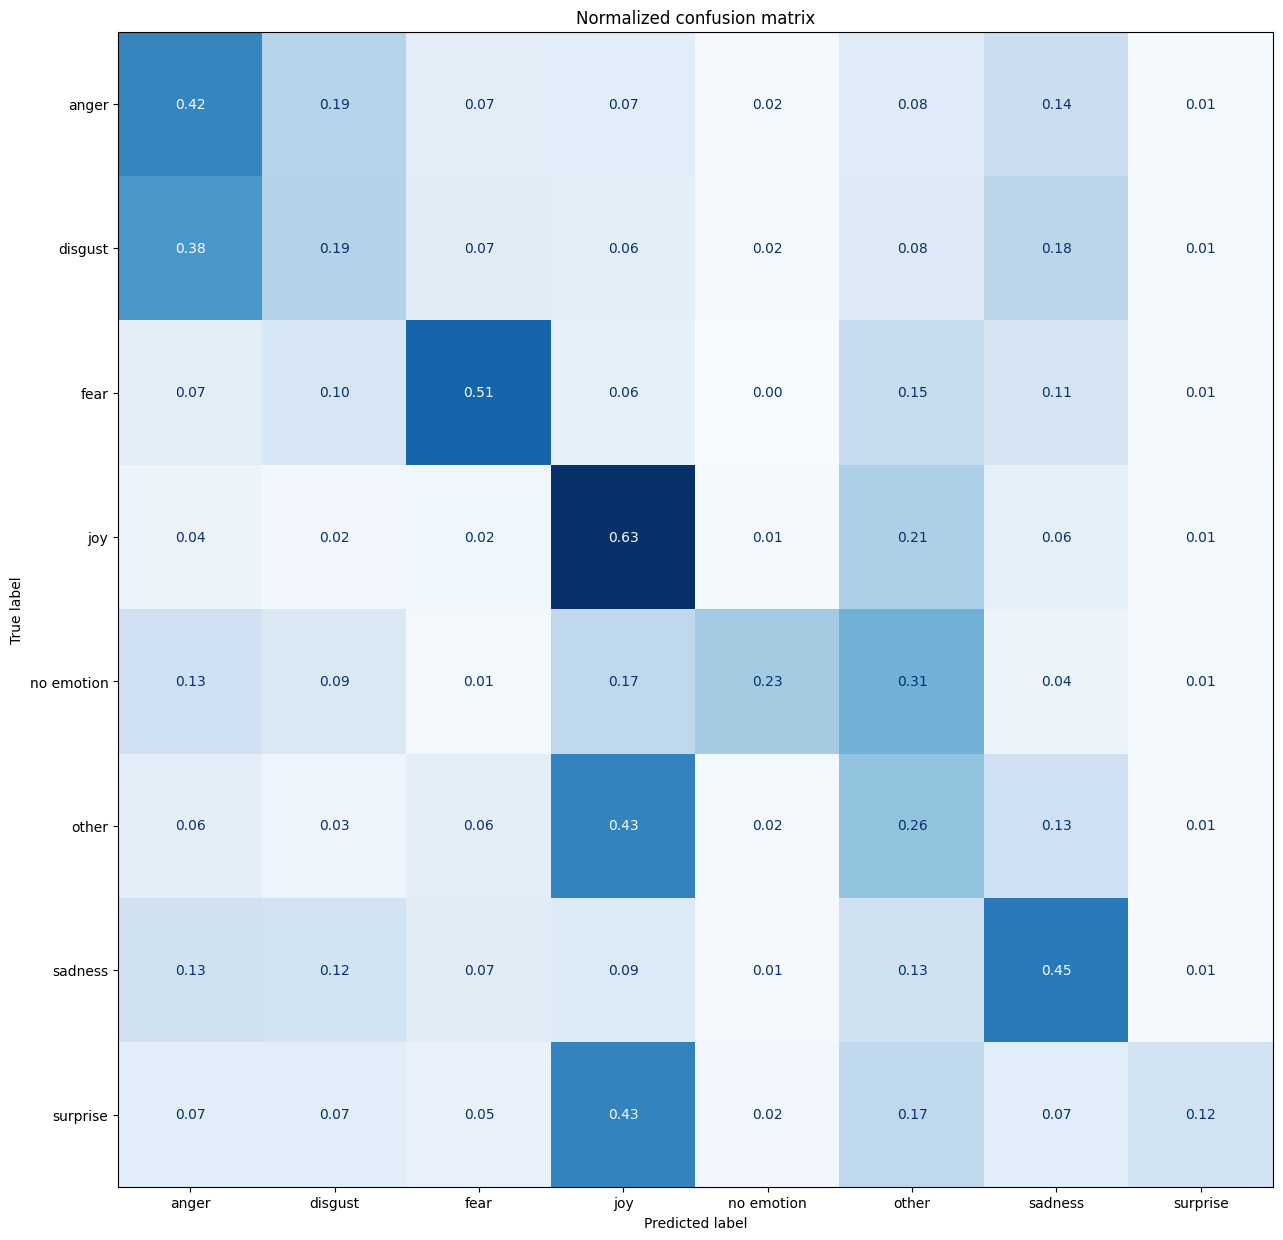

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(20, 15))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_pred, y_true, labels.names)

In [ ]:
from torch.nn.functional import cross_entropy
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Asegurarse de que el tokenizador esté correctamente configurado
transformer_model = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(transformer_model)
data_collator = DataCollatorWithPadding(tokenizer)

# Definir la función de forward pass con etiquetas
def forward_pass_with_label(batch):
    # Asegurarse de que los inputs estén correctamente formateados y en el dispositivo adecuado
    inputs = tokenizer(batch['Tweet'], padding=True, truncation=True, return_tensors="pt").to(device)
    labels = torch.tensor(batch["labels"]).to(device)
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, labels, reduction="none")
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

# Formatear el dataset a formato python para mapear la función
tokenized_dataset.set_format("python", columns=["Tweet", "labels"])

# Aplicar la función forward_pass_with_label al dataset de prueba
tokenized_dataset["test"] = tokenized_dataset["test"].map(forward_pass_with_label, batched=True, batch_size=16)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/7186 [00:00<?, ? examples/s]

In [ ]:
def label_int2str(row):
    return tokenized_dataset["train"].features["labels"].int2str(row)

In [ ]:
tokenized_dataset.set_format("pandas")
cols = ["Tweet", "labels", "predicted_label", "loss"]
df = tokenized_dataset["test"][:][cols]
df["labels"] = df["labels"].apply(label_int2str)
df["predicted_label"] = (df["predicted_label"]
                              .apply(label_int2str))

In [ ]:
loss_values = df.sort_values("loss", ascending=False).head(50)
loss_values

,Tweet,labels,predicted_label,loss
6162,"@ajduey04303 We've been broken up a while, bot...",no emotion,sadness,8.054910
6115,@washingtonpost WP your the mouthpiece for the...,no emotion,anger,7.938722
3576,Easiest subversive way to #bully someone in th...,no emotion,anger,7.790894
1632,@funnyrealfact Thx 4 follow! I #terrify with l...,fear,other,7.757844
1386,2 more months marks my #2year #alcohol # free ...,no emotion,joy,7.693918
5034,I have to bury another person this year at the...,anger,joy,7.646300
848,@littlebcstcrd Pardon me 😃,no emotion,joy,7.391113
3778,if we're mutuals don't hesitate to kit fisto's...,no emotion,other,7.388573
1394,@Good2bqueen67 @foxandfriends @realDonaldTrump...,joy,disgust,7.294012
5588,My soon to be ex wife needs to learn to chill ...,anger,joy,7.283052


In [ ]:
loss_values.to_csv('/content/drive/MyDrive/E-c_AIT-EN/loss_values_extended_model_finetuning.tsv',header =True, sep = '\t',index=False)
df.to_csv('/content/drive/MyDrive/E-c_AIT-EN/preds_extended_model_finetuning.tsv',header =True, sep = '\t',index=False)